#### **Regression-Analysis-Team-Project** by Team 1

# Zillow Prize: Zillow’s Home Value Prediction (Zestimate)
### Can you improve the algorithm that changed the world of real estate?

---
## 목차
#### 1. Data Introduce
#### 2. EDA
- 주제별 변수의 의미, 분포 등 탐색
- 주제별 변수와 logerror의 관계 탐색

#### 3. Feature Engineering
- Missing value imputation
- Feature Correlation

#### 4. Modeling
- Model:
    - OLS Model
    - XGBoost
- Target Prediction
---

##### Importing necessary libraries

In [4]:
####### what's in startup file #######
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

In [3]:
####### what's not in startup file #######
from scipy import stats

# visualization in jupyter
%matplotlib inline   

# ignore warning messeges
import warnings
warnings.filterwarnings('ignore')

import time

# **1. Data Introduce**

## 1.1 Purpose

#### 1. Target: log-error
- log-error between their Zestimate(house price estimation) and the actual sale price
- $logerror=log(Zestimate)−log(SalePrice)$

#### 2. Feature
- all given features of a home 

#### 3. Kaggle Submission
- properties에 대한 2016년 10/11월/12월 & 2017년 10/11/12월 6개 시점의 logerror를 예측
- 하지만 시계열 분석이 현 시점에서는 어렵기 때문에 2016년과 2017년의 예측치 두 값만을 내는 것을 목표로 함

# **1. Data Introduce**

## 1.1 Purpose

#### 1. Target: log-error
- log-error between their Zestimate(house price estimation) and the actual sale price
- $logerror=log(Zestimate)−log(SalePrice)$

#### 2. Feature
- all given features of a home 

#### 3. Kaggle Submission
- properties에 대한 2016년 10/11월/12월 & 2017년 10/11/12월 6개 시점의 logerror를 예측
- 하지만 시계열 분석이 현 시점에서는 어렵기 때문에 2016년과 2017년의 예측치 두 값만을 내는 것을 목표로 함

## 1.2 Data set
- A full list of real estate properties in three counties (Los Angeles, Orange and Ventura, California)

### 1) Properties data
- 구성
    - properties_2016.csv - all the properties with their home features for 2016
    - properties_2017.csv - all the properties with their home features for 2017
- Propertie data는 2016년과 2017년 모두 (2985217 * 58)로 shape이 동일함 
    - (2985217개의 집에 대한 58개 특징 변수)
- 2016년과 2017년 data의 parcelid는 완전히 동일함, 즉 두 데이터는 같은 집들에 대한 2개 년도의 집의 특징에 대한 자료임

##### Importing data
- Properties Data

In [2]:
prop16 = pd.read_csv('data/properties_2016.csv')
prop17 = pd.read_csv('data/properties_2017.csv')

In [3]:
print("shape of prop16: ", prop16.shape)
print("shape of prop17: ", prop17.shape)

shape of prop16:  (2985217, 58)
shape of prop17:  (2985217, 58)


In [4]:
# prop16과 prop17의 parcelid를 합쳤을 때 개수를 확인 (join="inner": 두 column에 다 있는 경우 결합)
id16 = prop16["parcelid"].rename(columns={"parcelid":"2016"})
id17 = prop16["parcelid"].rename(columns={"parcelid":"2017"})
id = pd.concat([id16, id17], axis=1, join='inner') 
print("shape of id: ", id.shape)
id[0][id[0]!=id[1]]    # 2016과 2017이 다를 때로 filtering

shape of id:  (2985217, 2)


Series([], Name: 0, dtype: int64)

### 2) Train data: 거래된 집에 대한 데이터
- parcelid, transaction date, logerror 3개 column으로 이루어짐
- 구성
    - train_2016.csv - the training set with transactions from 1/1/2016 to 12/31/2016
    - train_2017.csv - the training set with transactions from 1/1/2017 to 9/15/2017    
- 2016년 data는 90275건의 거래를, 2017년 data는 77613건의 거래를 포함하고 있음 

##### Importing data
- Train Data

In [5]:
train16 = pd.read_csv('data/train_2016_v2.csv', parse_dates=["transactiondate"])
train17 = pd.read_csv('data/train_2017.csv', parse_dates=["transactiondate"])

In [6]:
print("shape of train16: ",train16.shape)
print("shape of train17: ",train17.shape)

shape of train16:  (90275, 3)
shape of train17:  (77613, 3)


### 3) Submission sample
- properties data에 있는 모든 집들의 6개 시점 logerror 예측치 작성<br/>

*shape of submission_form:  (2985217, 7)*

# **2. EDA - Exploring the Data!**

## 2.1 Merging Train and Properties Data

### 1) 분석을 위해 하나의 Train Data로 만들기
1. 각 년도의 train data를 기준으로 properties data를 merge함 (거래마다 그 집의 특징을 properties에서 가져옴)
2. merge한 2016년 data와 2017년 data를 (위아래로) 연결함
3. 결과적으로 2016년~2017년의 모든 거래에 대해 해당하는 집의 특징을 merge한 하나의 train data가 구성됨
    - shape: (167888, 60)

In [9]:
# traing16을 기준으로 prop16을 merge
merged16 = pd.merge(train16, prop16, on="parcelid", how="left")

In [10]:
# traing17을 기준으로 prop17을 merge
merged17 = pd.merge(train17, prop17, on="parcelid", how="left")

In [11]:
merged = pd.concat([merged16, merged17]).reset_index(drop=True)
merged.tail()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
167883,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13
167884,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13
167885,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13
167886,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13
167887,12826780,0.007204,2017-09-25,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,NaN,NaN,140000.0,522000.0,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13


In [12]:
print("shape of merged: ", merged.shape)

shape of merged:  (167888, 60)


### 2) Status of merged data
- merged data를 전체적으로 살펴보고 data format 등 인코딩을 바꿔줄 부분을 전처리함
- 그 결과 2016년&2017년의 167,888건의 거래에 대해 61개 변수를 가진 하나의 data가 만들어짐
    - 변수: logerror(target), 거래날짜(전체, 년, 월), properties data(해당 거래 년도의 data)
- 카테고리 타입 변수가 많고, 변수들의 missing value가 매우 많음

In [13]:
merged_des = merged.describe(include='all').transpose()
merged_des["missing_ratio"] = 1-(merged_des["count"]/merged.shape[0])
merged_des["dtype"] = merged.dtypes
merged_des.reset_index().tail()

,index,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
55,landtaxvaluedollarcnt,167851,NaN,NaN,NaN,NaN,NaN,288880,445645,22,83730,197776,355334,4.89522e+07,0.000220385,float64
56,taxamount,167843,NaN,NaN,NaN,NaN,NaN,5989.52,7214.73,19.92,2798.07,4501.04,6914.16,586639,0.000268036,float64
57,taxdelinquencyflag,4683,1,Y,4683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.972106,object
58,taxdelinquencyyear,4683,NaN,NaN,NaN,NaN,NaN,13.8272,2.42166,3,13,14,15,99,0.972106,float64
59,censustractandblock,167002,NaN,NaN,NaN,NaN,NaN,6.04939e+13,1.05414e+12,6.0371e+13,6.03731e+13,6.0376e+13,6.05904e+13,4.8303e+14,0.00527733,float64


##### Data의 format 등에 먼저 전처리를 해줄 수 있는 부분

In [14]:
# transaction date을 year와 month로 분리해 줌
merged['transaction_year'] = merged['transactiondate'].dt.year
merged['transaction_month'] = merged['transactiondate'].dt.month

# taxdelinquency는 "Y"를 True로 바꾸어 줌 (다른 dummy 변수들은 1이나 True로 되어 있음)
merged['taxdelinquencyflag'] = merged['taxdelinquencyflag'].replace('Y',True)
merged['taxdelinquencyflag'] = merged['taxdelinquencyflag'].fillna(False)

# taxdelinquencyyear는 4자리의 년도로 format을 맞춰줌
merged["taxdelinquencyyear"] = merged["taxdelinquencyyear"].apply(lambda x: x + 2000 if x <= 17 else x + 1900)

# 위도 경도를 원래 단위로 맞춰줌
merged["latitude"] = merged["latitude"]/1000000
merged["longitude"] = merged["longitude"]/1000000

##### categorical / numerical variable 구분하기

In [15]:
vars = merged_des.reset_index()["index"].tolist()

cat_vars = ['transactiondate', 'transaction_year', 'transaction_month',
            'rawcensustractandblock', 'censustractandblock', 'fips',
            'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 
            'architecturalstyletypeid', 'decktypeid', 'buildingclasstypeid', 'storytypeid',
            'typeconstructiontypeid', 'propertycountylandusecode', 'propertylandusetypeid',
            'propertyzoningdesc', 'taxdelinquencyflag', 'taxdelinquencyyear', 'assessmentyear',
            'heatingorsystemtypeid', 'airconditioningtypeid', 'hashottuborspa', 'fireplaceflag',
            'pooltypeid10', 'pooltypeid2', 'pooltypeid7']

num_vars = [i for i in vars if i not in cat_vars]

num_vars.remove('parcelid')
num_vars.remove('logerror')

print("number of categorical variables:", len(cat_vars))
print("number of numerical variables:", len(num_vars))

number of categorical variables: 28
number of numerical variables: 32


##### 카테고리 변수 중 float type이 많음 → 필요할 경우 str으로 바꿔주기
- str: 'architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'fips', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 'propertylandusetypeid', 'heatingorsystemtypeid', 'airconditioningtypeid'
    - 일단 년도 변수는 계산 등의 조작 가능성을 고려해 바꿔주지 않음: 'assessmentyear', 'taxdelinquencyyear'
- boolean: 'fireplaceflag', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'hashottuborspa'

In [16]:
def cat_to_str(column_name):
    merged[column_name] = merged[column_name].astype("str")
    merged[column_name][merged[column_name] == 'nan'] = np.nan

In [17]:
c_to_s = ['architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock',
             'regionidcounty', 'fips', 'regionidcity', 'regionidcounty', 'regionidneighborhood',
             'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid',
             'propertylandusetypeid', 'heatingorsystemtypeid', 'airconditioningtypeid']

for var in c_to_s:
    cat_to_str(var)

In [18]:
# dummy 변수를 True/False로 인코딩
def cat_to_bln(column_name):
    merged[column_name] = merged[column_name].replace(1,True)
    merged[column_name] = merged[column_name].fillna(False)

In [19]:
c_to_b = ['fireplaceflag', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'hashottuborspa']

for var in c_to_b:
    cat_to_bln(var)

In [20]:
merged_des = merged.describe(include='all').transpose()
merged_des["missing_ratio"] = 1-(merged_des["count"]/merged.shape[0])
merged_des["dtype"] = merged.dtypes
merged_des

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
parcelid,167888,NaN,NaN,NaN,NaN,NaN,1.29954e+07,3.01607e+06,1.07117e+07,1.1549e+07,1.25406e+07,1.42193e+07,1.67689e+08,0,int64
logerror,167888,NaN,NaN,NaN,NaN,NaN,0.0139063,0.165706,-4.65542,-0.0253,0.006,0.0392,5.263,0,float64
transactiondate,167888,616,2017-06-30 00:00:00,1195,2016-01-01 00:00:00,2017-09-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,datetime64[ns]
airconditioningtypeid,53788,6,1.0,49854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.67962,object
architecturalstyletypeid,468,6,7.0,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997212,object
basementsqft,93,NaN,NaN,NaN,NaN,NaN,695.376,583.952,38,280,588,819,3560,0.999446,float64
bathroomcnt,167854,NaN,NaN,NaN,NaN,NaN,2.28827,1.00084,0,2,2,3,20,0.000202516,float64
bedroomcnt,167854,NaN,NaN,NaN,NaN,NaN,3.04174,1.14913,0,2,3,4,16,0.000202516,float64
buildingclasstypeid,31,2,4.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999815,object
buildingqualitytypeid,107173,NaN,NaN,NaN,NaN,NaN,6.01546,1.8828,1,4,7,7,12,0.36164,float64


## 2.2 Exploring Target Variable: logerror

### 1) logerror의 분포
- logerror의 평균은 약 0.01로 zestimation의 logerror는 평균적으로 0에 가까이 있음 (집값 예측이 대체로 잘 되고 있음)
- 대부분의 값들이 평균인 0 근처에 모여있고, 정규분포와 비슷한 형태를 보이지만 logerror가 상대적으로 큰 outliers들 존재
- logerror는 평균인 0 근처를 기준으로 음수와 양수 양방향으로 분포하고 있음

In [21]:
merged_des.loc[["logerror"], ['mean', 'std', 'min','25%', '50%', '75%', 'max']]

,mean,std,min,25%,50%,75%,max
logerror,0.0139063,0.165706,-4.65542,-0.0253,0.006,0.0392,5.263


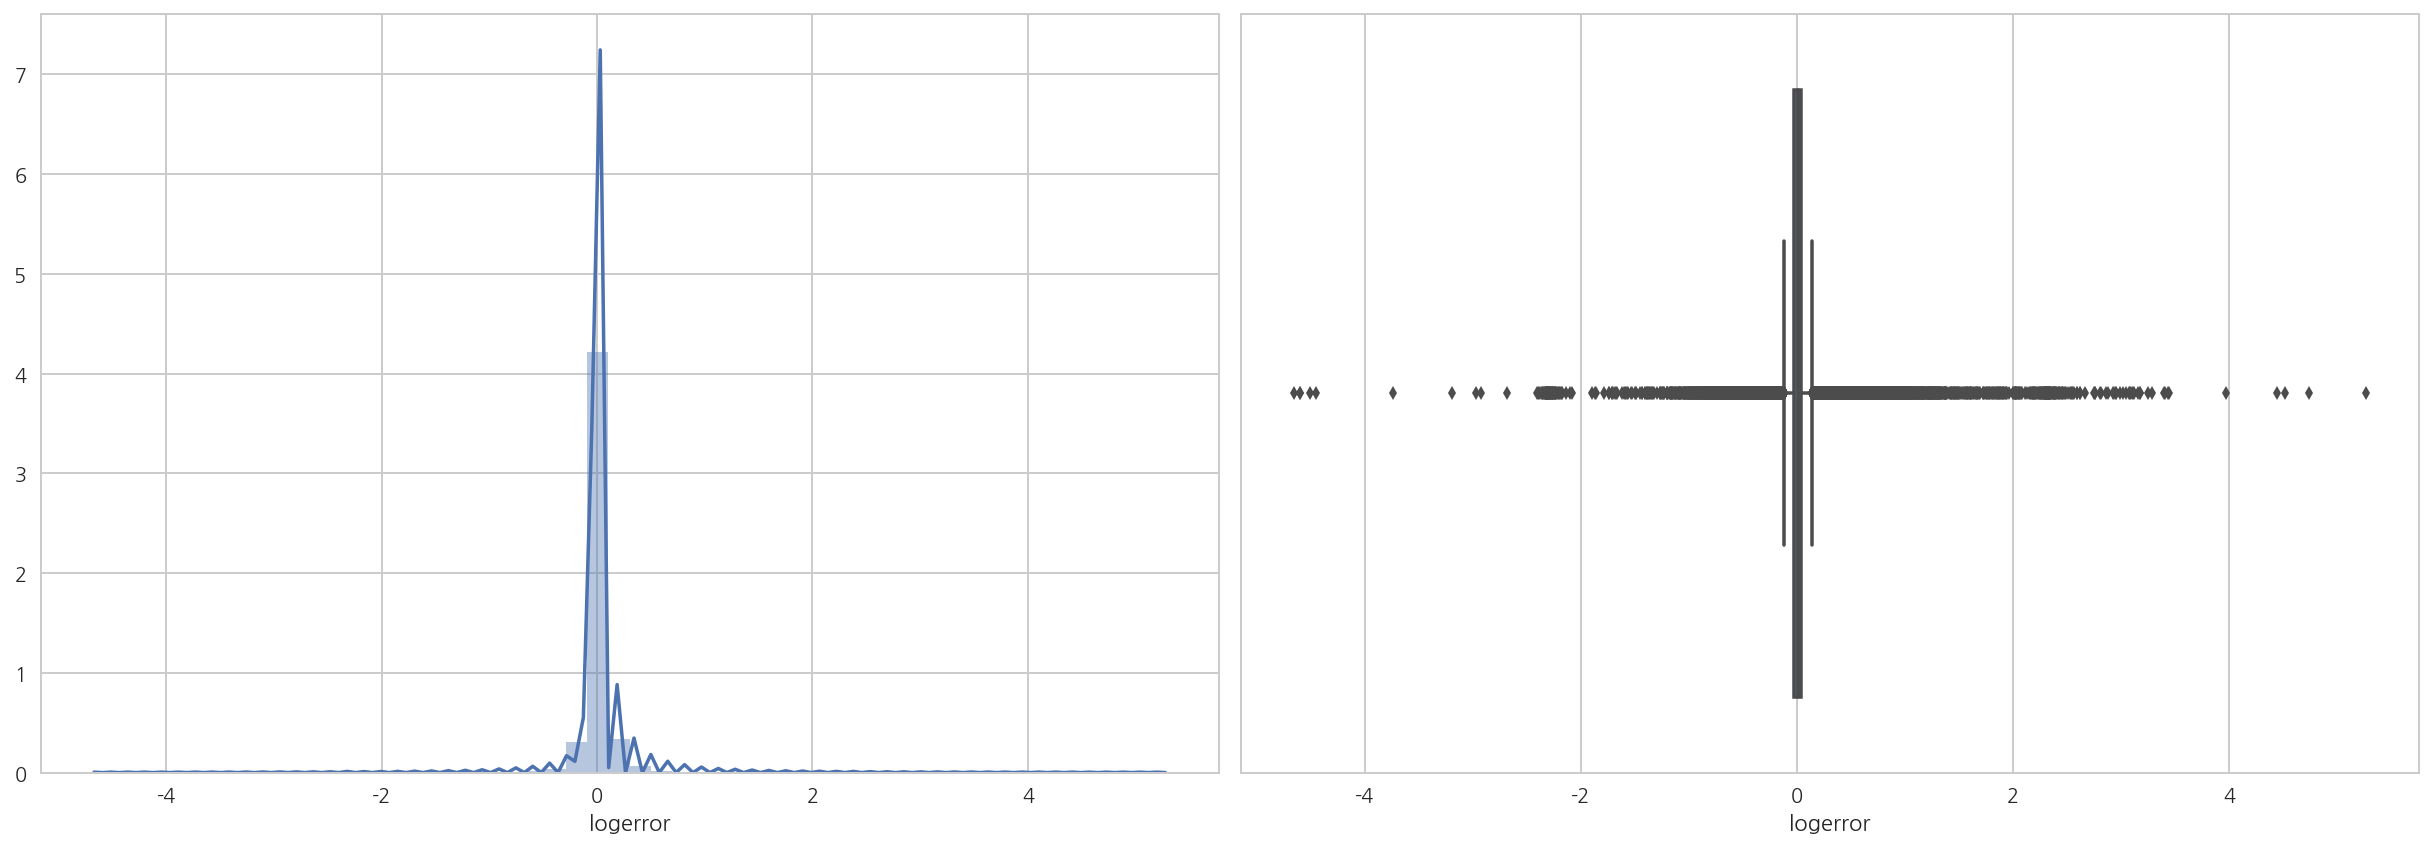

In [22]:
plt.figure(figsize=(17,6))

plt.subplot(121)
sns.distplot(merged["logerror"])

plt.subplot(122)
sns.boxplot(merged["logerror"])
plt.tight_layout()
plt.show()

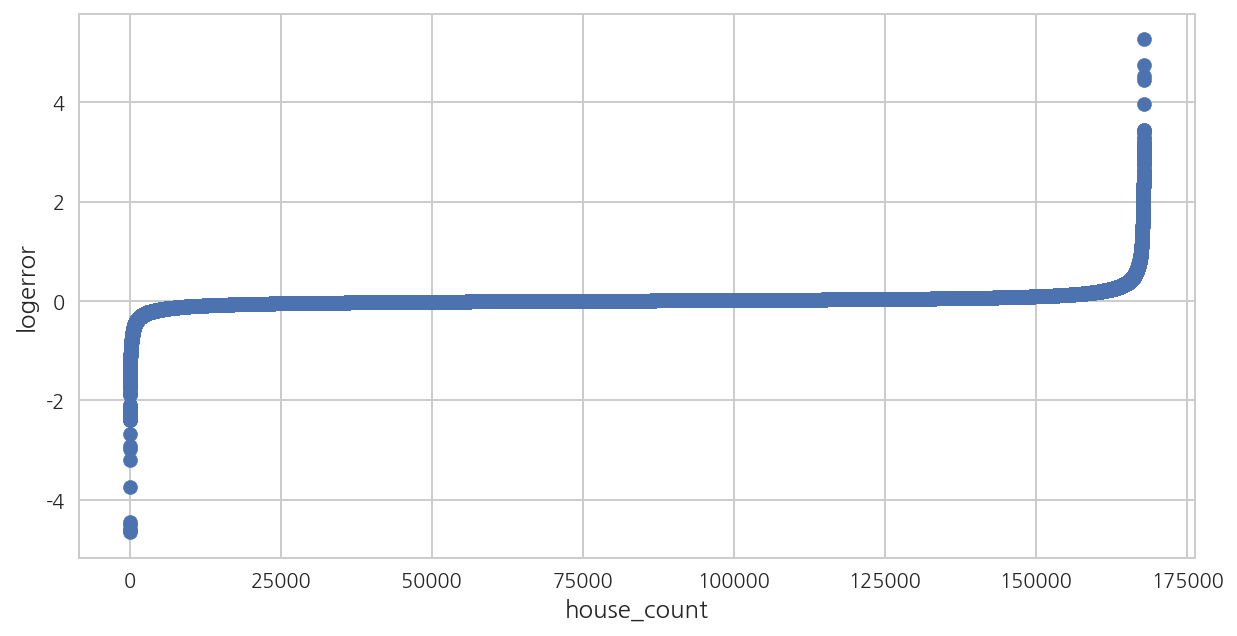

In [23]:
# logerror를 작은 값부터 정렬하여 분포를 살핌
plt.figure(figsize=(10,5))
plt.scatter(range(merged.shape[0]), np.sort(merged["logerror"]))
plt.xlabel('house_count', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

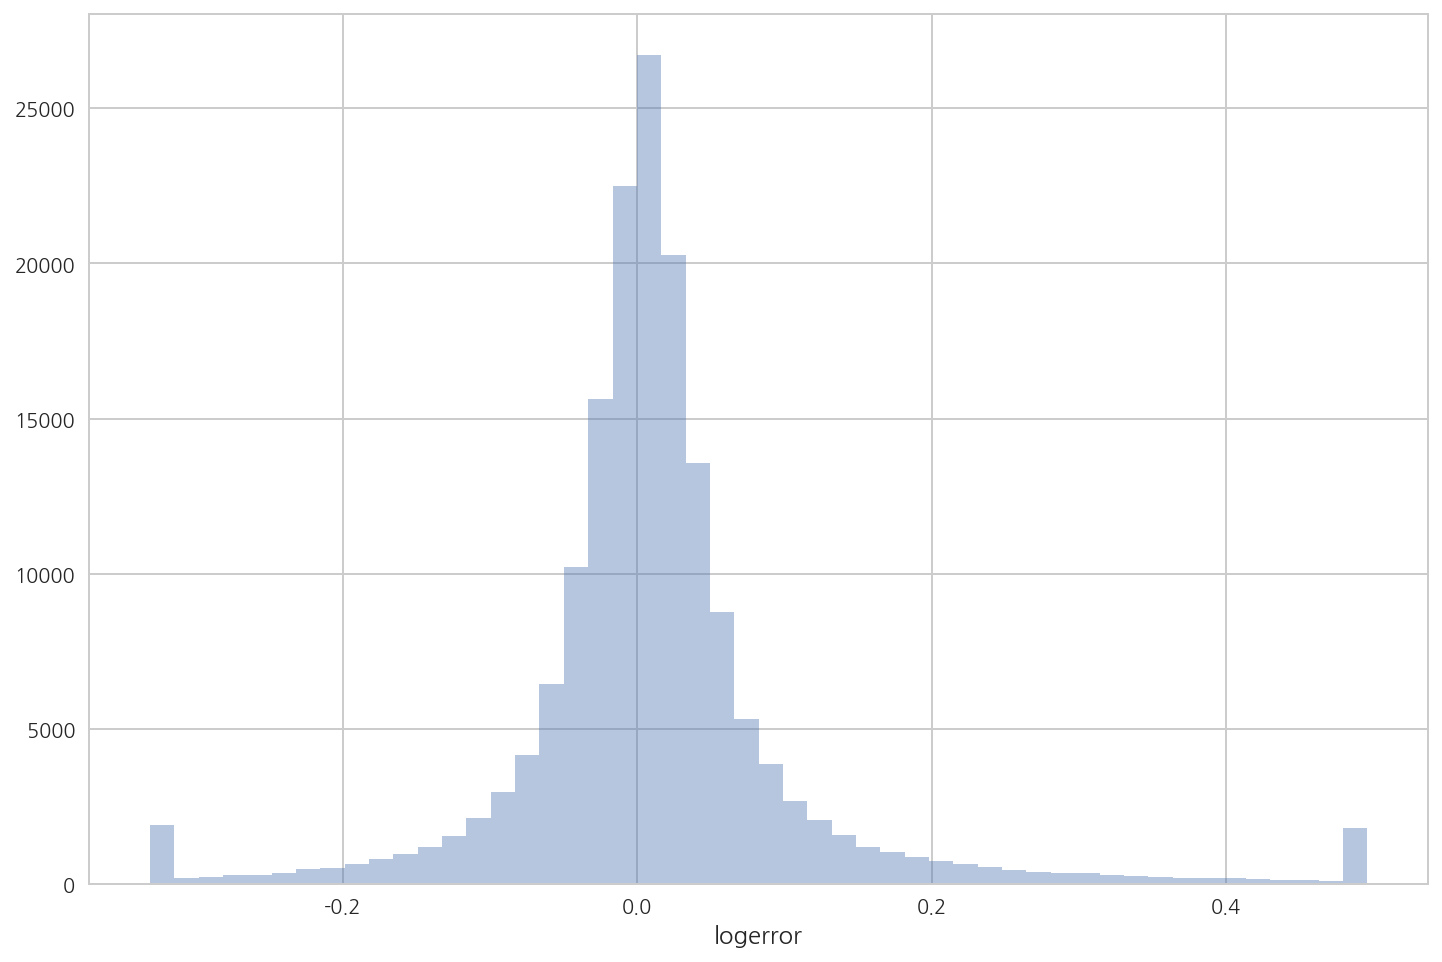

In [24]:
# 양 끝의 1%는 끝에 모아서 세워 그린 histogram
ulimit = np.percentile(merged.logerror.values, 99)
llimit = np.percentile(merged.logerror.values, 1)
merged['logerror'].loc[merged['logerror']>ulimit] = ulimit
merged['logerror'].loc[merged['logerror']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(merged["logerror"], bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

## 2.3 Exploring Feature Variables
- 독립변수를 주제별로 그룹지어 EDA
    - 변수의 의미, 분포를 파악
    - 적절한 missing value imputation 방안 
    - 추가적인 변수를 만들어낼 수 있는지 고민
- 주제별 분류
    1. 거래 날짜
    2. 집의 지리정보와 관련된 변수 (위도 경도 제외 카테고리 변수)
    3. 건물 특징, 타입 등에 대한 변수 (카테고리 변수)
    4. 집의 면적, 구조 등에 관련된 변수 (실수 변수 / 카테고리 변수)
    5. 세금과 관련된 변수 (실수 변수 / 카테고리 변수)    

### 1) 거래 관련 변수
- parcelid:
    - 대부분의 집들은 한번씩 거래됨 (거래횟수는 최대 3회까지 존재)
    - merged data의 167888개 row에서 unique한 parcelid의 개수는 165210개
- transactiondate

##### (1) parcelid: 집들은 몇번씩 거래되었나?

In [24]:
count = pd.DataFrame(columns=['count_all', 'count_2016', 'count_2017'])
count['count_all'] = (merged['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count['count_2016'] = (train16['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count['count_2017'] = (train17['parcelid'].value_counts().reset_index())['parcelid'].value_counts()
count['index'] = ["1회", "2회", "3회"]
count.set_index("index")

,count_all,count_2016,count_2017
index,,,
1회,162541,90026,77218
2회,2660,123,193
3회,9,1,3


In [25]:
len(list(merged["parcelid"].unique()))

165210

##### (2) transactiondate: 시점별 거래량과 logerror분포는 어떠한가?

##### 연도 및 월별 거래량

In [26]:
transaction_2016_month = merged["transaction_month"][merged['transaction_year'] == 2016].value_counts().reset_index()
transaction_2016_month = transaction_2016_month.rename(columns={'index':'month','transaction_month':'transaction_count'})
transaction_2016_month['year']=2016

In [27]:
transaction_2017_month = merged["transaction_month"][merged['transaction_year'] == 2017].value_counts().reset_index()
transaction_2017_month = transaction_2017_month.rename(columns={'index':'month','transaction_month':'transaction_count'})
transaction_2017_month['year']=2017

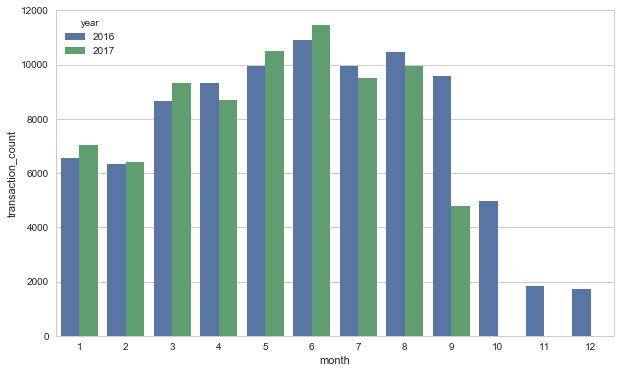

In [28]:
transaction_df = pd.concat([transaction_2016_month, transaction_2017_month]).reset_index(drop=True)
plt.figure(figsize=(10,6))
sns.barplot(data=transaction_df, x="month",y="transaction_count", hue="year")
plt.show()

##### 연도 및 월별 logerror

In [29]:
transaction_logerror_df = merged[['logerror','transaction_year','transaction_month']]
transaction_logerror_df.tail()

,logerror,transaction_year,transaction_month
167883,-0.002245,2017,9
167884,0.020615,2017,9
167885,0.013209,2017,9
167886,0.037129,2017,9
167887,0.007204,2017,9


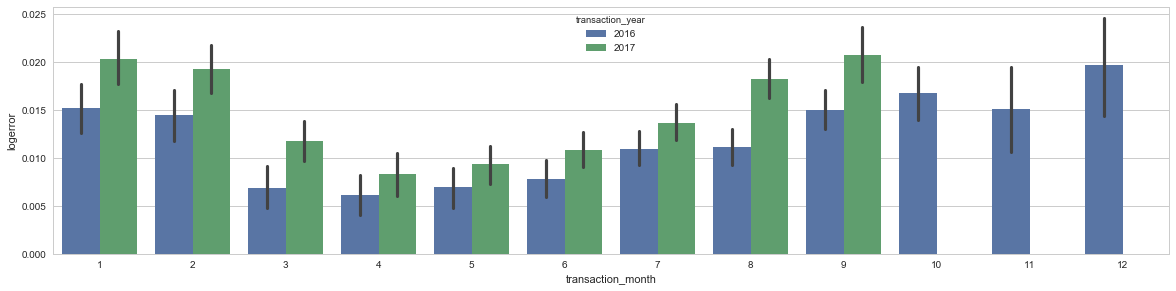

In [147]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2, 1, 1)
sns.barplot(x = 'transaction_month', y = 'logerror', hue = "transaction_year", data = merged, ax = ax1)

# ax2 = plt.subplot(2, 1, 2)
# sns.stripplot(x = "transaction_month", y = "logerror", hue = "transaction_year",dodge=True, data = merged, ax = ax2)

plt.show()

![](image/stripplot.png)

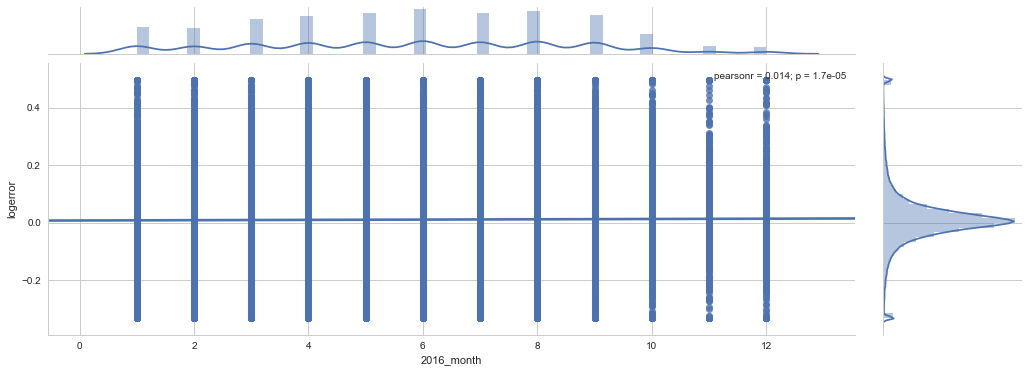

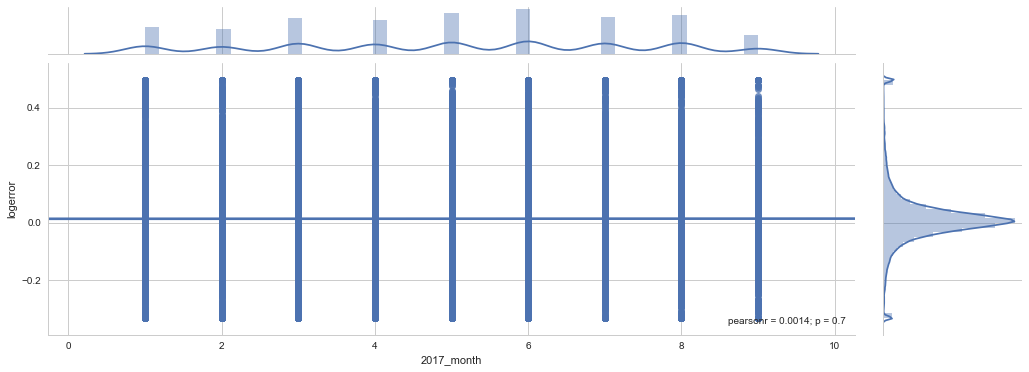

In [31]:
grid_1 = sns.jointplot(x = "transaction_month", y = "logerror", kind= "reg", size=8, data = merged[merged["transaction_year"]==2016])\
.set_axis_labels("2016_month", "logerror")
grid_1.fig.set_size_inches(15, 5)

grid_2 = sns.jointplot(x = "transaction_month", y = "logerror", kind= "reg", size=8, data = merged[merged["transaction_year"]==2017])\
.set_axis_labels("2017_month", "logerror")
grid_2.fig.set_size_inches(15, 5)

### 2) 집의 지리정보와 관련된 변수
- numerical variables: latitude, longitude
- categorical variables: fips, rawcensustractandblock, censustractandblock, regionidcounty, regionidcity, regionidzip, regionidneighborhood
    - county level 정보를 담고 있는 변수: fips, rawcensustractandblock와 censustractandblock의 앞 네 자리 코드
    - city level 이하의 정보를 담보 있는 변수: rawcensustractandblock와 censustractandblock의 5번째 자리 이후 코드, regionidcounty, regionidcity, regionidzip, regionidneighborhood

In [32]:
merged_des.loc[["fips","latitude", "longitude","rawcensustractandblock", "censustractandblock", "regionidcounty", "regionidcity",
                "regionidzip", "regionidneighborhood", "logerror"],["count", "mean", "min", "max", "dtype", "missing_ratio"]]

,count,mean,min,max,dtype,missing_ratio
fips,167854,NaN,NaN,NaN,object,0.000202516
latitude,167854,34.0068,33.3393,34.8188,float64,0.000202516
longitude,167854,-118.201,-119.475,-117.555,float64,0.000202516
rawcensustractandblock,167854,NaN,NaN,NaN,object,0.000202516
censustractandblock,167002,NaN,NaN,NaN,object,0.00527733
regionidcounty,167854,NaN,NaN,NaN,object,0.000202516
regionidcity,164579,NaN,NaN,NaN,object,0.0197096
regionidzip,167769,96586.4,95982,399675,float64,0.000708806
regionidneighborhood,66986,NaN,NaN,NaN,object,0.601008
logerror,167888,0.0139063,-4.65542,5.263,float64,0


##### latitude & longitude

In [33]:
merged[["latitude","longitude"]].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
latitude,167854.0,34.006778,0.265118,33.339295,33.812924,34.021700,34.173420,34.818767
longitude,167854.0,-118.201117,0.360059,-119.475416,-118.413025,-118.176852,-117.924692,-117.554636


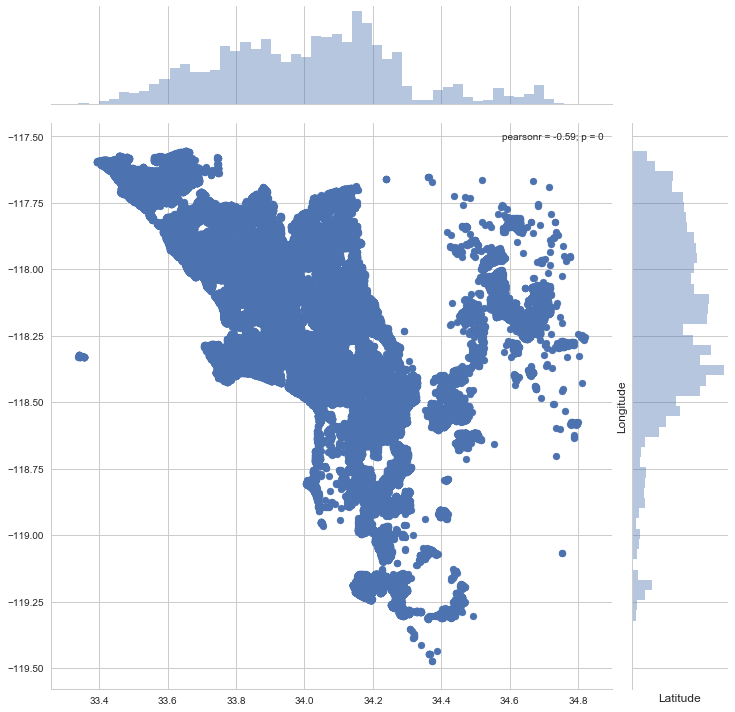

In [34]:
plt.figure(figsize=(8, 8))
sns.jointplot(x=merged.latitude.values, y=merged.longitude.values, size=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

##### **(1) county level의 정보를 나타내는 변수들**
- fips & regionidcounty: 완전히 동일한 정보를 가짐
    - fips: 6037=Los Angeles, 6059=Orange, 6111=Ventura County (6=CA)
    - regionidcounty: 3101=Los Angeles, 1286=Orange, 2061=Ventura County
- censustractandblock & rawcensustractandblock의 앞 네자리: fips 값을 담고 있음
- 집들은 LA(가장 많음), Orange, Ventura(가장 적음) 순으로 분포되어 있음
- 위 변수들은 사실상 거의 동일한 정보를 가지고 있음

In [48]:
# cencus와 rawcensus의 앞 네자리로 변수를 만들고 다른 변수들과 묶기
merged["census_1"] = merged["censustractandblock"].astype("str").apply(lambda x: x[:4])
merged["census_1"][merged["census_1"] == 'nan'] = np.nan
merged["raw_census_1"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[:4])
merged["raw_census_1"][merged["raw_census_1"] == 'nan'] = np.nan
county_df = merged[["fips", "regionidcounty", "census_1", "raw_census_1","logerror"]].tail()
county_df.tail()

,fips,regionidcounty,census_1,raw_census_1,logerror
167883,6037.0,3101.0,6037,6037,-0.002245
167884,6037.0,3101.0,6037,6037,0.020615
167885,6111.0,2061.0,6111,6111,0.013209
167886,6037.0,3101.0,6037,6037,0.037129
167887,6037.0,3101.0,6037,6037,0.007204


In [49]:
# 변수별 분포
fips = merged["fips"].value_counts().reset_index().rename(columns={"index": "fips", "fips":"counts"})
regionidcounty = merged["regionidcounty"].value_counts().reset_index().rename(columns={"index": "regionidcounty", "regionidcounty":"counts"})
census_1 = merged["census_1"].value_counts().reset_index().rename(columns={"index": "census_1", "census_1":"counts"})
raw_census_1 = merged["raw_census_1"].value_counts().reset_index().rename(columns={"index": "raw_census_1", "raw_census_1":"counts"})
pd.concat([fips, regionidcounty, raw_census_1, census_1], axis=1)

,fips,counts,regionidcounty,counts,raw_census_1,counts,census_1,counts
0,6037.0,109270.0,3101.0,109270.0,6037,109270.0,6037,108757
1,6059.0,45136.0,1286.0,45136.0,6059,45136.0,6059,44894
2,6111.0,13448.0,2061.0,13448.0,6111,13448.0,6111,13340
3,NaN,NaN,NaN,NaN,NaN,NaN,6071,8
4,NaN,NaN,NaN,NaN,NaN,NaN,6065,2
5,NaN,NaN,NaN,NaN,NaN,NaN,4830,1


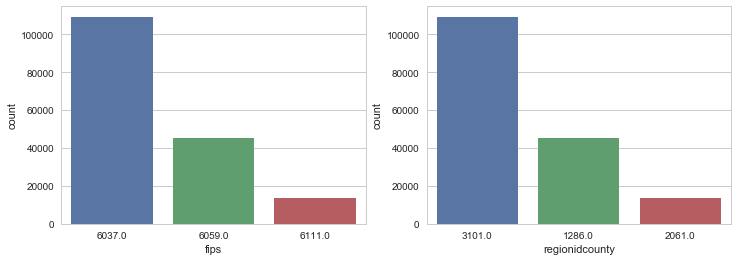

In [37]:
plt.figure(figsize=(12, 4))
ax1 = plt.subplot(1, 2, 1)
sns.countplot(x = 'fips', data = merged, ax = ax1)

ax2 = plt.subplot(1, 2, 2)
sns.countplot(x = 'regionidcounty', data = merged, ax = ax2)

##### **(2) City level 이하의 정보를 나타내는 변수들**
- regionidcity: 179개 class
- census_2 & raw_census_2 (censustractandblock & rawcensustractandblock의 5-10의 여섯자리): census tract 값을 담고 있음 (유사한 인구적 특성을 가짐)
    - 각각 3017개, 3024개 class
- regionidzip: 391개 class
    - 입력오류로 보이는 3396765는 NaN값 처리
- regionidneighborhood: 506개 class 
    - missing value ratio가 60% 이상으로 꽤 높은데, imputation하기 어려울 것 같음

In [25]:
# censustractandblock & rawcensustractandblock의 5-10자리 부분: census tract → class가 3000개 이상이라 너무 많은 것으로 생각됨
merged["census_2"] = merged["censustractandblock"].astype("str").apply(lambda x: x[4:10])
merged["census_2"][merged["census_2"] == ""] = np.nan
census_2 = pd.DataFrame(merged["census_2"])
census_2 = census_2.groupby("census_2").size().reset_index(name='counts')

merged["raw_census_2"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[4:11])
merged["raw_census_2"][merged["raw_census_2"] == ""] = np.nan
raw_census_2 = pd.DataFrame(merged["raw_census_2"])
raw_census_2 = raw_census_2.groupby("raw_census_2").size().reset_index(name='counts')

In [26]:
# censustractandblock & rawcensustractandblock의 5-10자리 부분 중 첫째 자리로 카테고리화 (카테고리 수를 줄임)
merged["census_3"] = merged["censustractandblock"].astype("str").apply(lambda x: x[4:5])
merged["census_3"][merged["census_3"] == ''] = np.nan
census_3 = pd.DataFrame(merged["census_3"])
census_3 = census_3.groupby("census_3").size().reset_index(name='counts')

merged["raw_census_3"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[4:5])
merged["raw_census_3"][merged["raw_census_3"] == ''] = np.nan
raw_census_3 = pd.DataFrame(merged["raw_census_3"])
raw_census_3 = raw_census_3.groupby("raw_census_3").size().reset_index(name='counts')

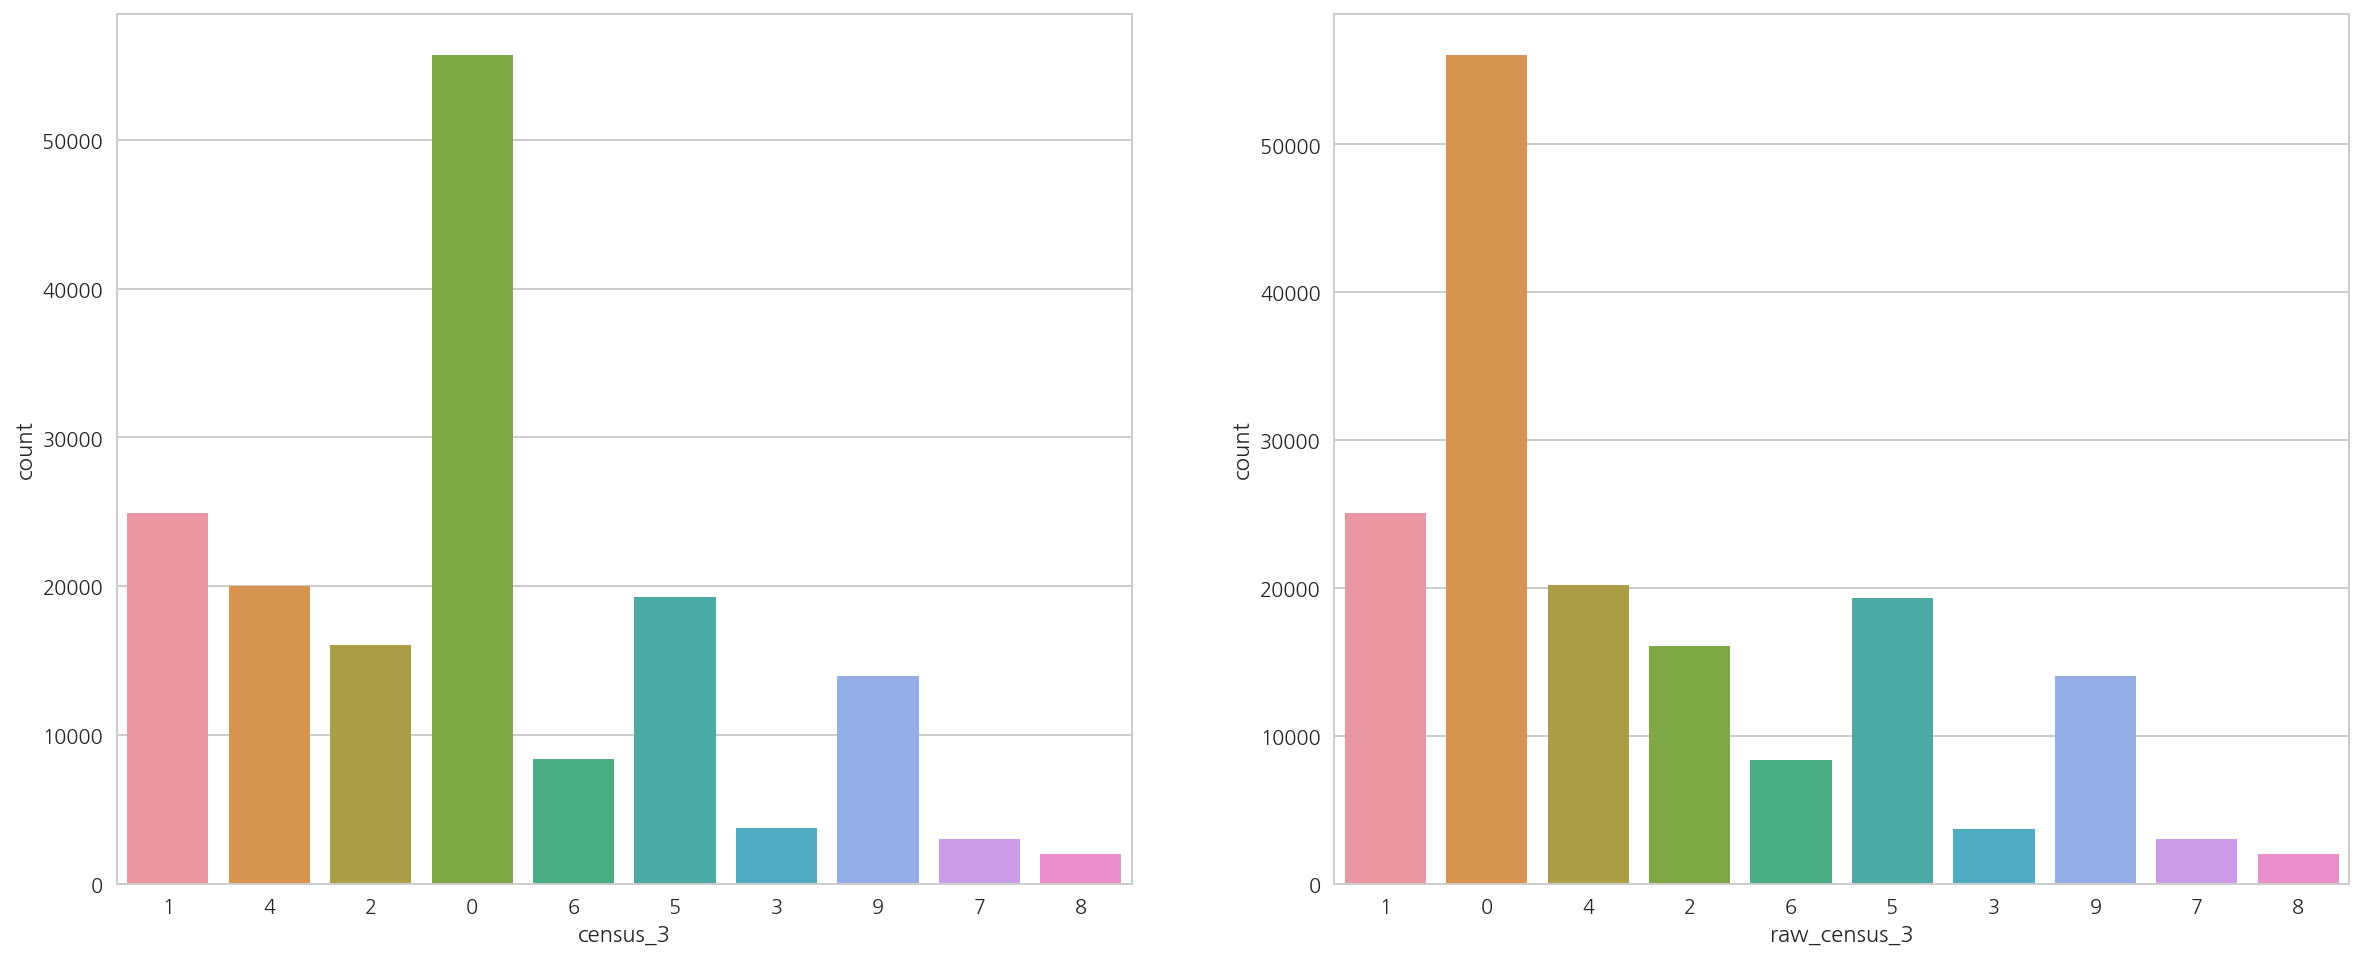

In [27]:
plt.figure(figsize=(20, 8))
ax1 = plt.subplot(1, 2, 1)
sns.countplot(x = 'census_3', data = merged, ax = ax1)

ax2 = plt.subplot(1, 2, 2)
sns.countplot(x = 'raw_census_3', data = merged, ax = ax2)
plt.show()

In [28]:
# censustractandblock & rawcensustractandblock의 1-5자리로 카테고리화
merged["census_4"] = merged["censustractandblock"].astype("str").apply(lambda x: x[:5])
merged["census_4"][merged["census_4"] == 'nan'] = np.nan
census_4 = pd.DataFrame(merged["census_4"])
census_4 = census_4.groupby("census_4").size().reset_index(name='counts')

merged["raw_census_4"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[:5])
merged["raw_census_4"][merged["raw_census_4"] == 'nan'] = np.nan
raw_census_4 = pd.DataFrame(merged["raw_census_4"])
raw_census_4 = raw_census_4.groupby("raw_census_4").size().reset_index(name='counts')

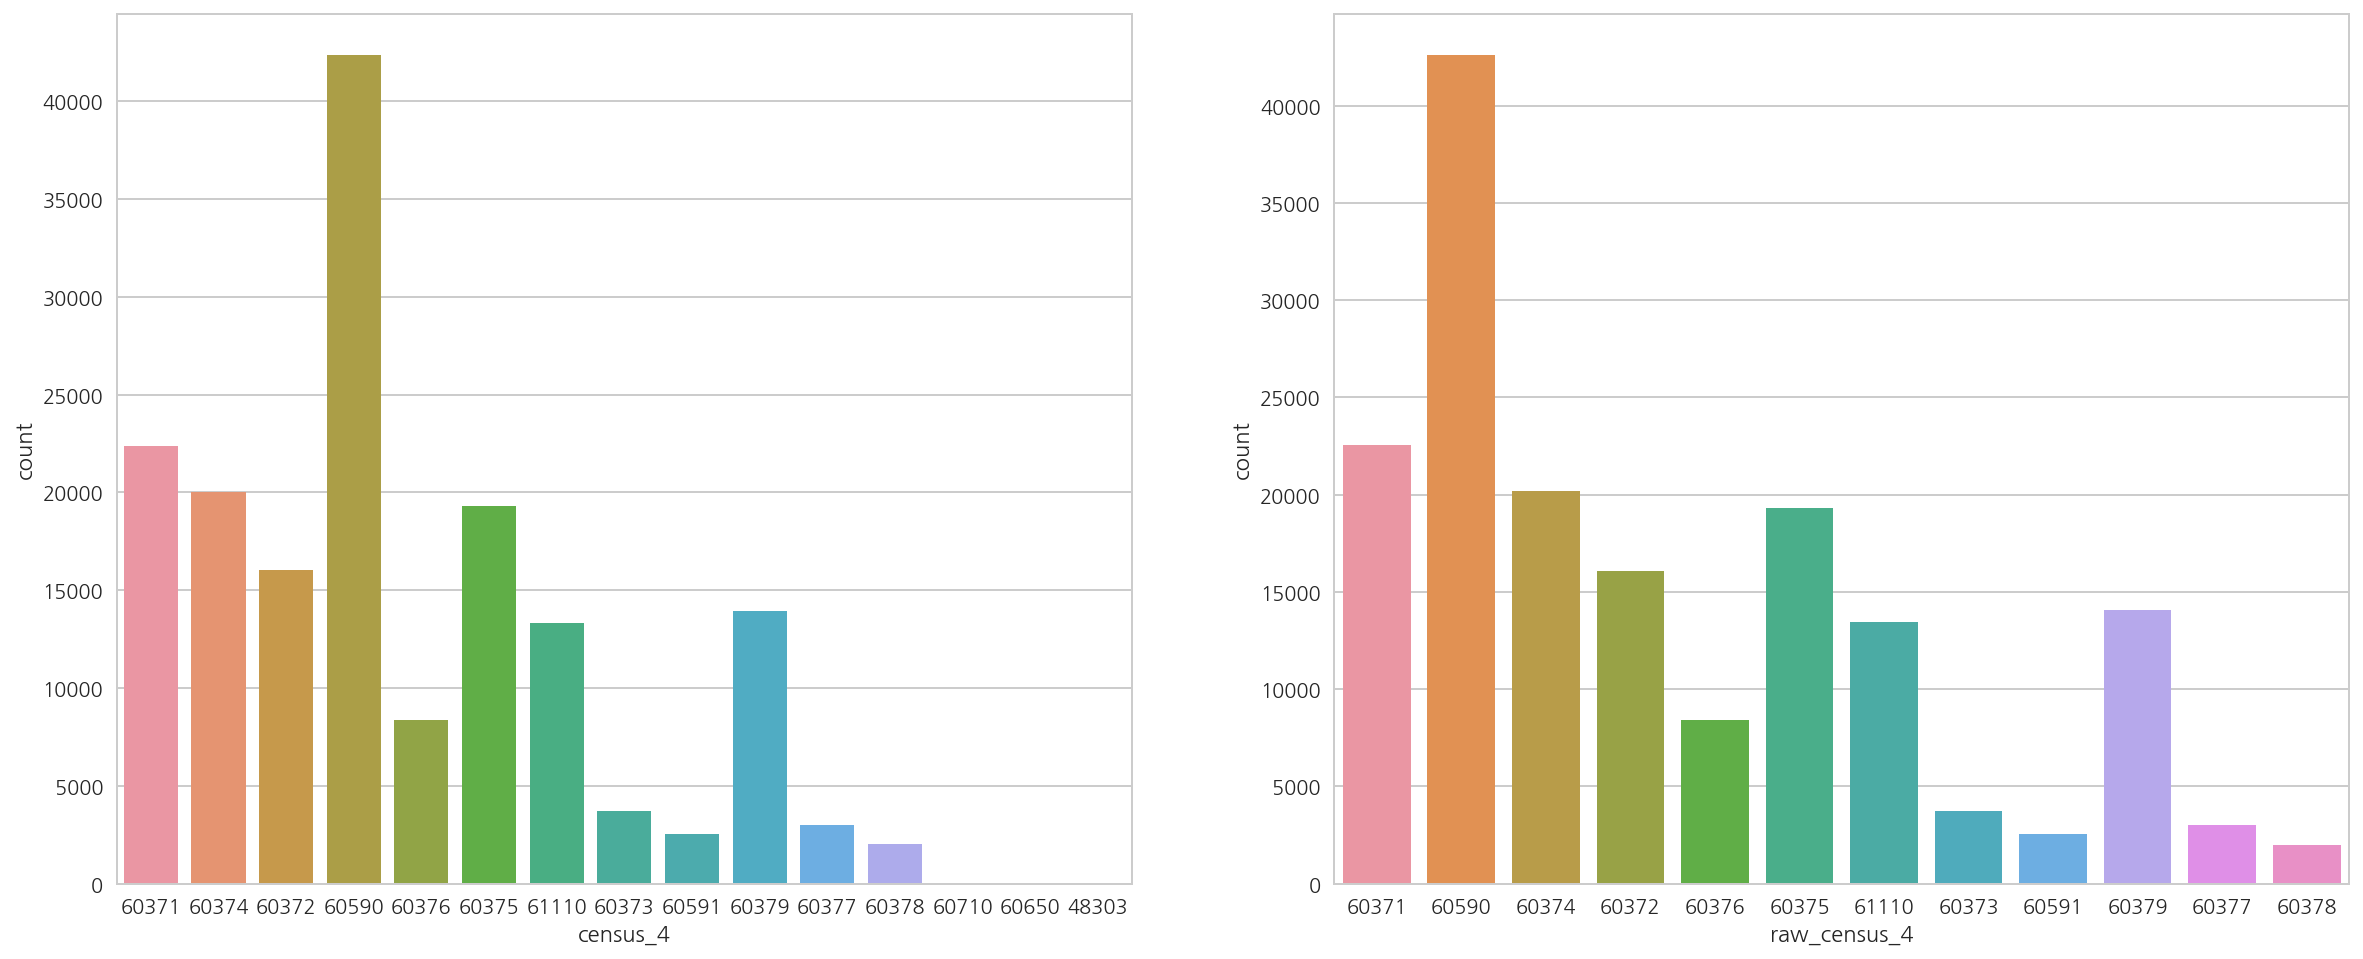

In [29]:
plt.figure(figsize=(20, 8))
ax1 = plt.subplot(1, 2, 1)
sns.countplot(x = 'census_4', data = merged, ax = ax1)

ax2 = plt.subplot(1, 2, 2)
sns.countplot(x = 'raw_census_4', data = merged, ax = ax2)
plt.show()

In [43]:
# what is 6-digit zip code??? (CA zipcode는 9로 시작하는 5자리수) (http://www.zipcodestogo.com/California/)
print("number of houses of wierd zipcode:", len(merged["regionidzip"][merged["regionidzip"] >= 100000]))
merged[merged["regionidzip"] >= 100000].tail()   # zipcode가 이상한 집들의 데이터 확인

number of houses of wierd zipcode: 25


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,transaction_year,transaction_month,census_1,raw_census_1,census_2,raw_census_2,census_3,raw_census_3,census_4,raw_census_4
146359,12969394,0.000630,2017-07-11,1.0,NaN,NaN,5.0,5.0,NaN,9.0,...,2017,7,6037,6037,430200,4302.00,4,4,60374,60374
153120,12969593,0.022602,2017-07-31,NaN,NaN,NaN,2.0,3.0,NaN,7.0,...,2017,7,6037,6037,430200,4302.00,4,4,60374,60374
160027,12969702,-0.126013,2017-08-24,1.0,NaN,NaN,3.0,4.0,NaN,8.0,...,2017,8,6037,6037,430200,4302.00,4,4,60374,60374
161938,12969611,-0.331138,2017-08-30,1.0,NaN,NaN,2.0,3.0,NaN,8.0,...,2017,8,NaN,6037,NaN,4302.00,NaN,4,NaN,60374
167393,12969775,0.035494,2017-09-15,1.0,NaN,NaN,3.0,5.0,NaN,7.0,...,2017,9,6037,6037,430200,4302.00,4,4,60374,60374


In [30]:
### 입력오류라고 보고 NaN값 처리
merged["regionidzip"][merged["regionidzip"]>=100000] = np.nan

In [31]:
### regionidneighborhood는 imputation이 어려울 것 같음 
regionidneighborhood = pd.DataFrame(merged["regionidneighborhood"])
regionidneighborhood = regionidneighborhood.groupby("regionidneighborhood").size().reset_index(name='counts')
regionidneighborhood.sort_values(by="counts", ascending = False).head(10)

,regionidneighborhood,counts
121,27080.0,1476
345,48570.0,1461
29,118208.0,1447
267,37739.0,1400
343,48200.0,1178
106,268496.0,1163
347,51906.0,1160
348,54300.0,1062
0,113455.0,988
166,274049.0,946


In [46]:
# regionidcity: 179개 클래스를 가진 카테고리 변수
print("class number of regionidcity:", len(merged["regionidcity"].unique()))

# census_2, raw_census_2: tract
print("class number of cencus_2(tract):", len(merged["census_2"].unique()))
print("class number of raw_cencus_2(tract):", len(merged["raw_census_2"].unique()))

# census_3, raw_census_3: tract 첫 글자
print("class number of cencus_3(tract_1st):", len(merged["census_3"].unique()))
print("class number of raw_cencus_3(tract_1st):", len(merged["raw_census_3"].unique()))

# census_4, raw_census_4: county + tract 첫글자
print("class number of cencus_4(county+tract_1st):", len(merged["census_4"].unique()))
print("class number of raw_cencus_4(county+tract_1st):", len(merged["raw_census_4"].unique()))

# regionidzip: 클래스가 391개인 카테고리 변수
print("class number of regionzip:", len(merged["regionidzip"].unique()))

# regionidneighborhood: class 506개
print("class number of regionidneighborhood:", len(merged["regionidneighborhood"].unique()))

class number of regionidcity: 179
class number of cencus_2(tract): 3018
class number of raw_cencus_2(tract): 3025
class number of cencus_3(tract_1st): 11
class number of raw_cencus_3(tract_1st): 11
class number of cencus_4(county+tract_1st): 16
class number of raw_cencus_4(county+tract_1st): 13
class number of regionzip: 390
class number of regionidneighborhood: 506


##### 집의 지리정보와 관련된 변수 정리

In [47]:
merged.loc[:,["latitude", "longitude","fips", "regionidcounty", "raw_census_2", "census_2",
              "raw_census_3", "census_3",  "raw_census_4", "census_4", "regionidcity",
              "regionidzip", "regionidneighborhood"]].describe(include="all").transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
latitude,167854,NaN,NaN,NaN,34.0068,0.265118,33.3393,33.8129,34.0217,34.1734,34.8188
longitude,167854,NaN,NaN,NaN,-118.201,0.360059,-119.475,-118.413,-118.177,-117.925,-117.555
fips,167854,3,6037.0,109270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
regionidcounty,167854,3,3101.0,109270,NaN,NaN,NaN,NaN,NaN,NaN,NaN
raw_census_2,167854,3024,0524.20,455,NaN,NaN,NaN,NaN,NaN,NaN,NaN
census_2,167002,3017,052420,444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
raw_census_3,167854,10,0,56037,NaN,NaN,NaN,NaN,NaN,NaN,NaN
census_3,167002,10,0,55699,NaN,NaN,NaN,NaN,NaN,NaN,NaN
raw_census_4,167854,12,60590,42589,NaN,NaN,NaN,NaN,NaN,NaN,NaN
census_4,167002,15,60590,42349,NaN,NaN,NaN,NaN,NaN,NaN,NaN


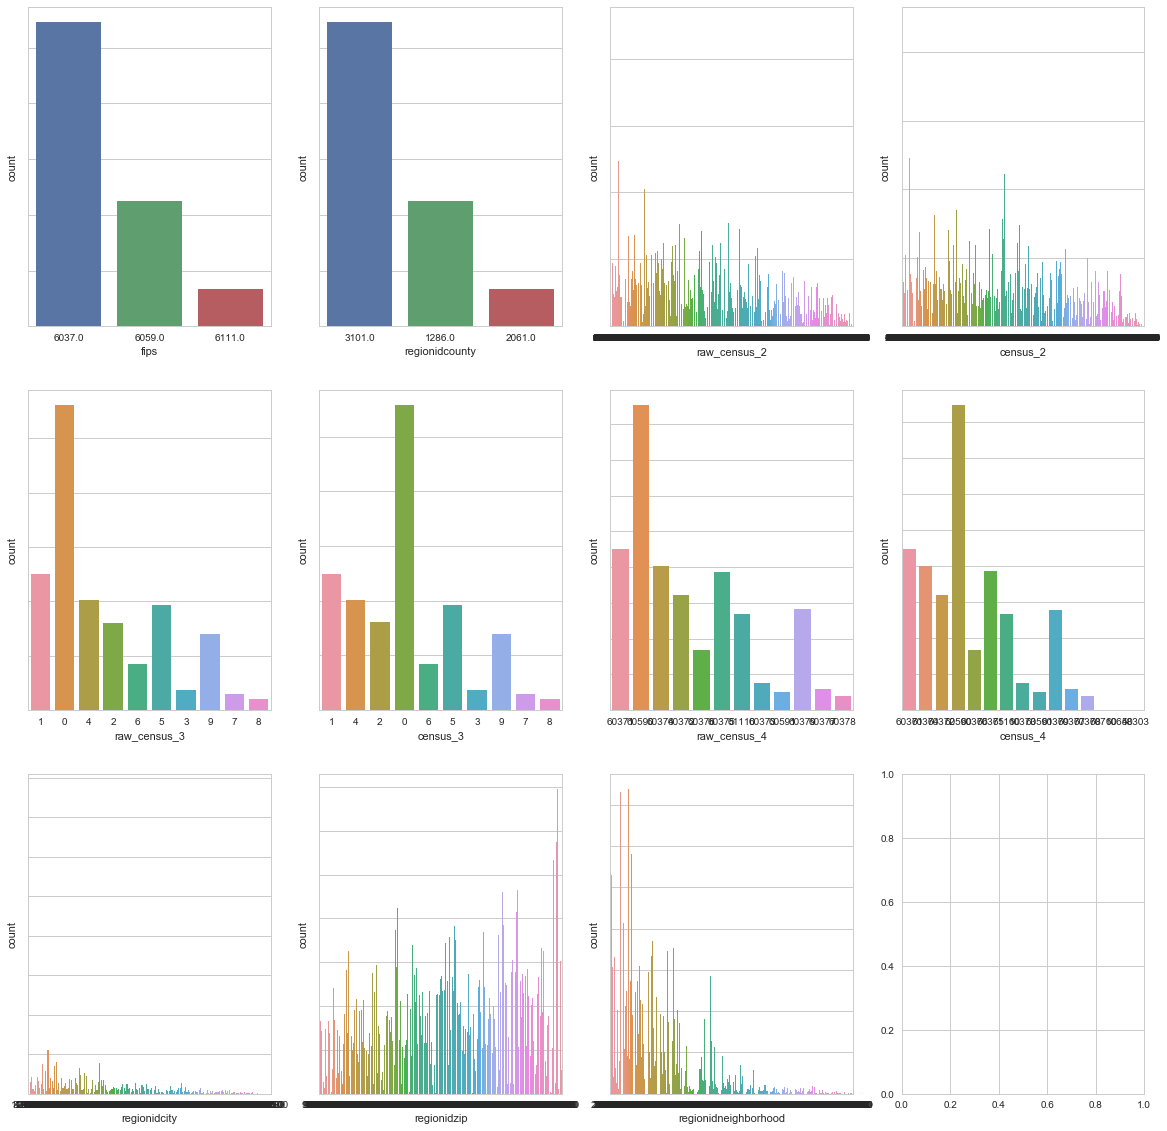

In [48]:
geo_cat = ["fips", "regionidcounty", "raw_census_2", "census_2",
           "raw_census_3", "census_3",  "raw_census_4", "census_4",
           "regionidcity", "regionidzip", "regionidneighborhood"]

fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(geo_cat):
    sns.countplot(x = n, data = merged, ax = ax[idx//4, idx % 4])
    ax[idx// 4, idx % 4].set(yticklabels=[])
    
    continue

### **3) 건물 특징, 타입 등에 대한 변수들**
- 건물의 특징 등에 대한 카테고리 변수들인데, missing value가 99% 이상인 값들이 많음
    - 최빈값으로 imputation 하고자 함
- numerical variable: buildingqualitytypeid (집에 대한 평가 점수 from 1 to 12)
- categorical variable: 
    - 건물 타입: architecturalstyletypeid, decktypeid, buildingclasstypeid, storytypeid, typeconstructiontypeid
    - 부지 용도 구분: propertycountylandusecode, propertylandusetypeid, propertyzoningdesc

In [49]:
merged_des.loc[["architecturalstyletypeid", "decktypeid", "buildingqualitytypeid", "buildingclasstypeid", "storytypeid",
              "typeconstructiontypeid", "propertycountylandusecode", "propertylandusetypeid", "propertyzoningdesc"],:]

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
architecturalstyletypeid,468,6,7.0,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997212,object
decktypeid,1272,1,66.0,1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.992424,object
buildingqualitytypeid,107173,NaN,NaN,NaN,NaN,NaN,6.01546,1.8828,1,4,7,7,12,0.36164,float64
buildingclasstypeid,31,2,4.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999815,object
storytypeid,93,1,7.0,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999446,object
typeconstructiontypeid,522,4,6.0,516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.996891,object
propertycountylandusecode,167853,90,0100,57628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000208472,object
propertylandusetypeid,167854,14,261.0,113078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000202516,object
propertyzoningdesc,108789,2346,LAR1,14444,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352014,object


- **buildingqualitytypeid**
    - Overall assessment of condition of the building from best (lowest) to worst (highest)
    - missing value ratio: 0.36164
- **architecturalstyletypeid**
    - 집의 건축 스타일에 대한 1부터 27까지 categorical data
    - 27가지 class 중에 6가지 값이 나옴
- **decktypeid**
    - deck이 있는 경우 deck의 type, but data dict.에 type 분류 설명이 없어 값이 있는 '66'이 무슨 의미인지 알 수 없음
    - missing value ratio: 0.992424 → NaN은 deck이 없는 것이라고 보고 0으로 imputation(dummy 변수화)
- **buildingclasstypeid**
    - 건물이 fireproofed한 frame(non-combustible)를 갖고 있는지 분류 (0-5 cateogories, 5=non of above)
    - missing value ratio: 0.999815
- **storytypeid**
    - Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.)
    - missing value ratio: 0.999446
- **typeconstructiontypeid**
    - What type of construction material was used to construct the home
    - missing value ratio: 0.996891

- **propertycountylandusecode**
    - County land use code i.e. it's zoning at the county level
    - 숫자와 알파벳으로 이루어진 1~4자리 문자열
    - 90개 class

In [50]:
merged["propertycountylandusecode"].unique()

array(['0100', '1', '010C', '122', '1129', '34', '1128', '010E', '0104',
       '0101', '0200', '0700', '1111', '01DC', '010D', '1110', '0400',
       '012C', '010V', '1116', '01HC', '010G', '0300', '010F', '1117',
       '0103', '38', '1210', '0111', '010M', '96', '135', '0108', '1014',
       '1112', '0201', '0109', '1310', '010H', '1410', '1222', '1321',
       '1720', '1011', '1432', '0401', '0102', '012D', '73', '105',
       '0110', '100V', '0130', '8800', '0303', '0210', '1012', '1333',
       '0114', '01DD', '020G', '040A', '012E', '020M', '040V', '070D',
       '1200', '030G', '1722', '6050', '1421', '010', nan, '200', '0',
       '1420', '0131', '0301', '01HE', '0204', '0113', '0133', '040G',
       '1120', '0105', '0141', '0115', '010L', '040B', '0203', '020E'],
      dtype=object)

In [51]:
propertycountylandusecode = pd.DataFrame(merged["propertycountylandusecode"])
propertycountylandusecode_count = propertycountylandusecode.groupby("propertycountylandusecode").size().reset_index(name='counts')

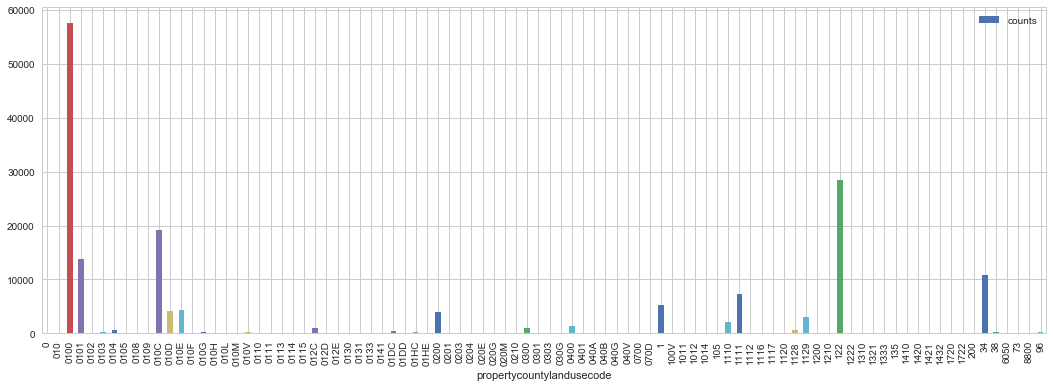

In [52]:
propertycountylandusecode_count.plot(x = 'propertycountylandusecode', y = 'counts', kind = 'bar', figsize=(18, 6))

- **propertylandusetypeid**
    - Type of land use the property is zoned for
    - 261 Single Family Residential과 266 Condominium이 데이터의 대부분을 차지함

- **propertyzoningdesc**
    - Description of the allowed land uses (zoning) for that property (Zoning affects what you can and cannot do with a property)
    - 알파벳과 숫자로 이루어진 문자열, 2347개 unique값, missing value ratio 35.2%
    - 주마다 zoning 규칙이 있지만 대체로 R이 residential, c는 commercial, I/M은 industrial 등으로 구분되어 있음
        - LA: https://library.municode.com/ca/los_angeles_county/codes/code_of_ordinances?nodeId=TIT22PLZO_DIV1PLZO_CH22.12ZODI_22.12.010ZODEURTAAU
        - Orange: https://library.municode.com/ca/orange/codes/code_of_ordinances?nodeId=TIT17ZO_CH17.06ZODIMA
        - Ventura: https://docs.vcrma.org/images/pdf/planning/ordinances/VCNCZO_Current.pdf
    - 코드를 살펴보면 앞의 두자리는 지역을 나타내는 것으로 추측
    - 첫번째 글자로 묶거나, 세번째자리 글자로 묶어 새로운 변수 두 가지를 만들어 봄    

In [53]:
pd.DataFrame(merged["propertyzoningdesc"].unique()).tail()

,0
2342,GARR-MD
2343,DUR120000*
2344,LCRA 7500*
2345,LCRA7000-R
2346,BFA15000*


In [54]:
propertyzoningdesc = merged["propertyzoningdesc"].value_counts().reset_index().rename(columns={"index": "propertyzoningdesc", "propertyzoningdesc":"counts"})
propertyzoningdesc.head()

,propertyzoningdesc,counts
0,LAR1,14444
1,LAR3,5251
2,LARS,2897
3,LBR1N,2684
4,LARD1.5,2437


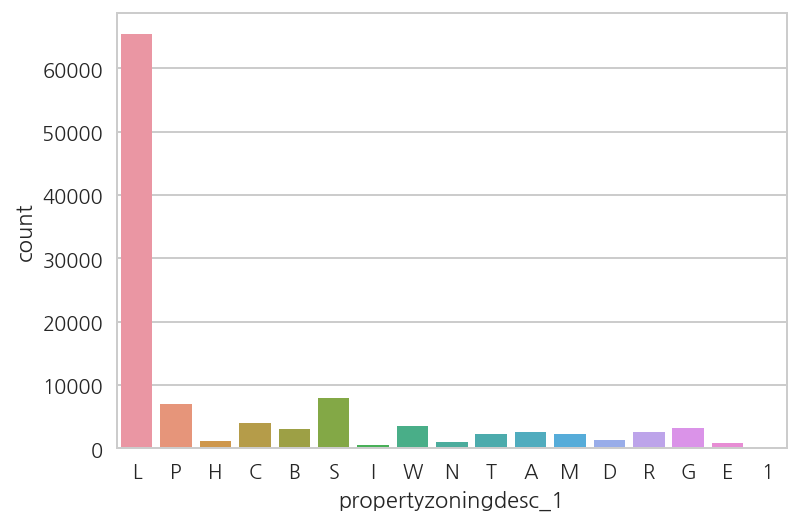

In [32]:
# 첫글자로 새로운 변수 만들기 (첫 글자로 카테고리화)
merged["propertyzoningdesc_1"] = merged["propertyzoningdesc"].astype("str").apply(lambda x: x[:1])
merged["propertyzoningdesc_1"][merged["propertyzoningdesc_1"] == "n"] = np.nan
sns.countplot(x = 'propertyzoningdesc_1', data=merged)
plt.show()

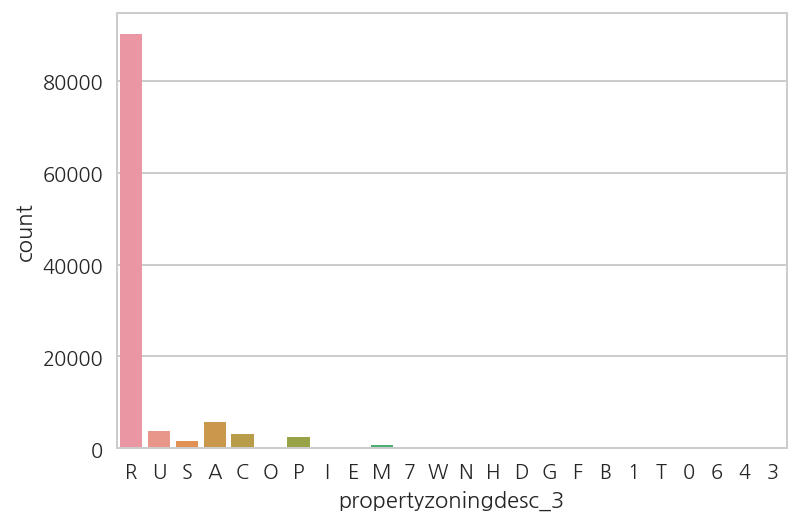

In [33]:
# 세번째 글자로 새로운 변수 만들기
merged["propertyzoningdesc_3"] = merged["propertyzoningdesc"].astype("str").apply(
    lambda x: x.replace("&", "").replace("-", "").replace(" ", ""))
merged["propertyzoningdesc_3"] = merged["propertyzoningdesc_3"].apply(lambda x: x[2:3])
merged["propertyzoningdesc_3"][merged["propertyzoningdesc_3"] == "n"] = np.nan
merged["propertyzoningdesc_3"][merged["propertyzoningdesc_3"] == ""] = np.nan
sns.countplot(x = 'propertyzoningdesc_3', data=merged)
plt.show()

##### 건물 특징, 타입 등에 대한 변수 정리

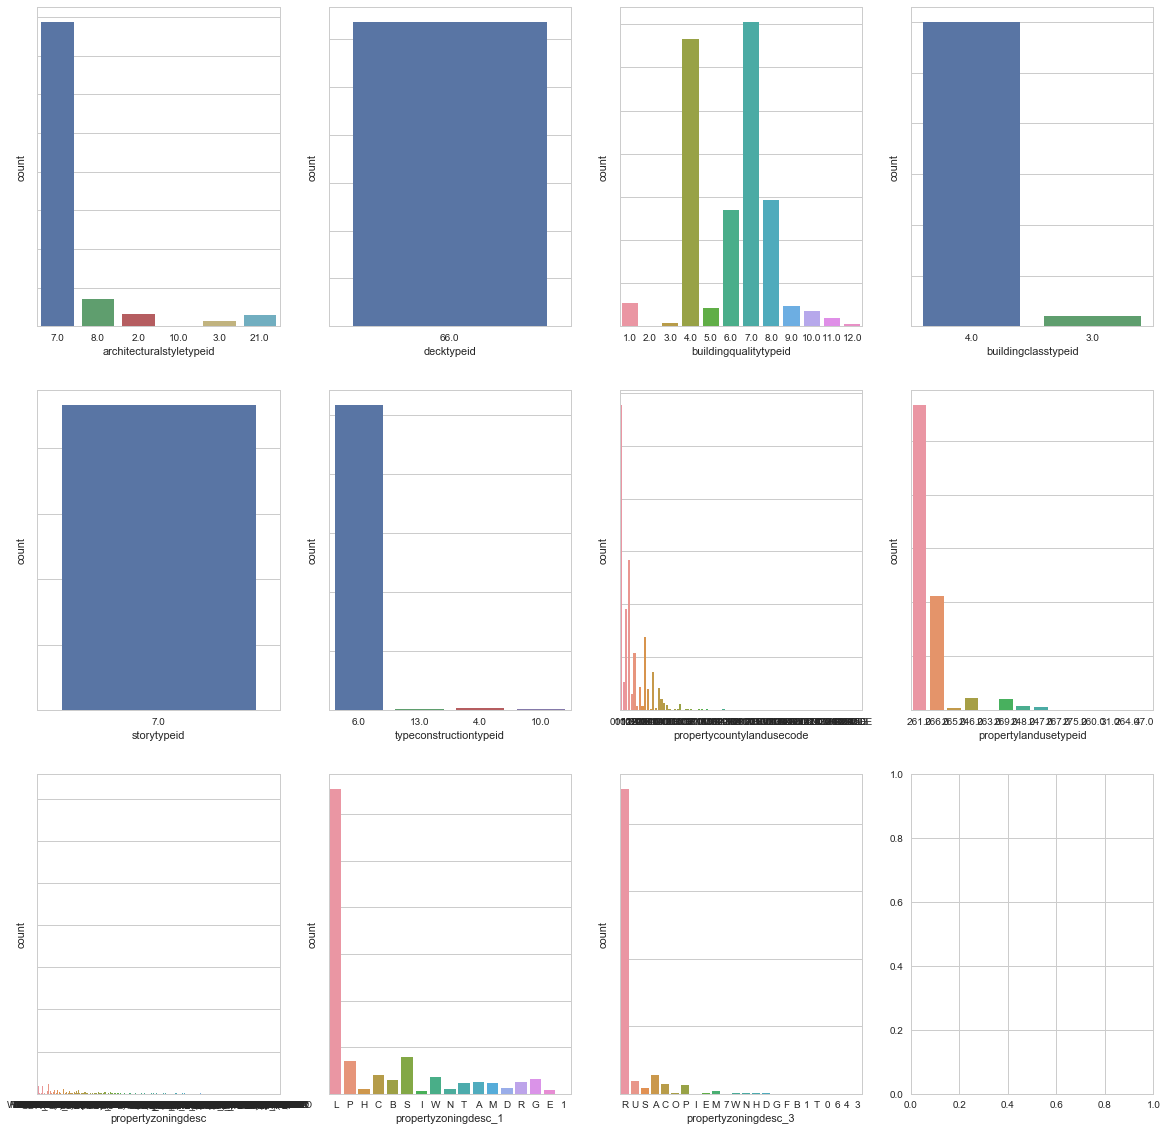

In [57]:
bdg_var = ["architecturalstyletypeid", "decktypeid", "buildingqualitytypeid", "buildingclasstypeid",
           "storytypeid", "typeconstructiontypeid", "propertycountylandusecode", "propertylandusetypeid",
           "propertyzoningdesc", "propertyzoningdesc_1", "propertyzoningdesc_3"]

fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(bdg_var):
    sns.countplot(x = n, data = merged, ax = ax[idx // 4, idx % 4])
    ax[idx // 4, idx % 4].set(yticklabels=[])
    
    continue

### **4)  집의 구조, 유틸, 면적 등에 관련된 변수**
- numerical variables: <br/>bathroomcnt, calculatedbathnbr, threequarterbathnbr, fullbathcnt, numberofstories, roomcnt, bedroomcnt, unitcnt, yearbuilt, fireplacecnt, poolcnt, basementsqft, finishedfloor1squarefeet, calculatedfinishedsquarefeet, finishedsquarefeet6, finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, yardbuildingsqft17, yardbuildingsqft26, garagecarcnt, garagetotalsqft, lotsizesquarefeet<br/>
<br/>
- categorical variables:<br/> fips, rawcensustractandblock, censustractandblock, regionidcounty, regionidcity, regionidzip, regionidneighborhood, heatingorsystemtypeid, airconditioningtypeid, hashottuborspa, pooltypeid10, pooltypeid2, pooltypeid7

#### **4-1) 집 구조 관련 변수**

In [58]:
merged_des.loc[["bathroomcnt", "calculatedbathnbr", "threequarterbathnbr", "fullbathcnt", "numberofstories", "roomcnt", "bedroomcnt", "unitcnt", "yearbuilt"],:]

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
bathroomcnt,167854,NaN,NaN,NaN,NaN,NaN,2.28827,1.00084,0,2,2,3,20,0.000202516,float64
calculatedbathnbr,166056,NaN,NaN,NaN,NaN,NaN,2.31254,0.977808,1,2,2,3,20,0.010912,float64
threequarterbathnbr,22115,NaN,NaN,NaN,NaN,NaN,1.00913,0.109294,1,1,1,1,7,0.868275,float64
fullbathcnt,166056,NaN,NaN,NaN,NaN,NaN,2.24534,0.964703,1,2,2,3,20,0.010912,float64
numberofstories,38169,NaN,NaN,NaN,NaN,NaN,1.43776,0.544508,1,1,1,2,6,0.772652,float64
roomcnt,167854,NaN,NaN,NaN,NaN,NaN,1.47748,2.8215,0,0,0,0,18,0.000202516,float64
bedroomcnt,167854,NaN,NaN,NaN,NaN,NaN,3.04174,1.14913,0,2,3,4,16,0.000202516,float64
unitcnt,109056,NaN,NaN,NaN,NaN,NaN,1.11037,0.988168,1,1,1,1,237,0.350424,float64
yearbuilt,166828,NaN,NaN,NaN,NaN,NaN,1968.57,23.7772,1824,1953,1970,1987,2016,0.00631373,float64


- missing value ratio가 특히 높은 변수는 "threequarterbathnbr"과 "numberofstories", 그리고 "unitcnt"

##### bathroom 관련 변수들
- fullbath란 tub까지 모두 갖춘 화장실, 3/4 bath란 tub이 없고 샤워부스만 있는 화장실, half bath는 변기와 세면대만 있는 화장실을 말함
- bathroomcnt와 calculatedbathnbr: Number of bathrooms in home including fractional bathrooms(=0.5?)
- threequarterbathnbr: missing value 높음 (imputation: 0 or 1)
- fullbathcnt

In [59]:
bathroomcnt = pd.DataFrame(merged["bathroomcnt"])
bathroomcnt = bathroomcnt.groupby("bathroomcnt").size().reset_index(name='counts')

In [60]:
calculatedbathnbr = pd.DataFrame(merged["calculatedbathnbr"])
calculatedbathnbr = calculatedbathnbr.groupby("calculatedbathnbr").size().reset_index(name='counts')

In [61]:
threequarterbathnbr = pd.DataFrame(merged["threequarterbathnbr"])
threequarterbathnbr = threequarterbathnbr.groupby("threequarterbathnbr").size().reset_index(name='counts')

In [62]:
fullbathcnt = pd.DataFrame(merged["fullbathcnt"])
fullbathcnt = fullbathcnt.groupby("fullbathcnt").size().reset_index(name='counts')

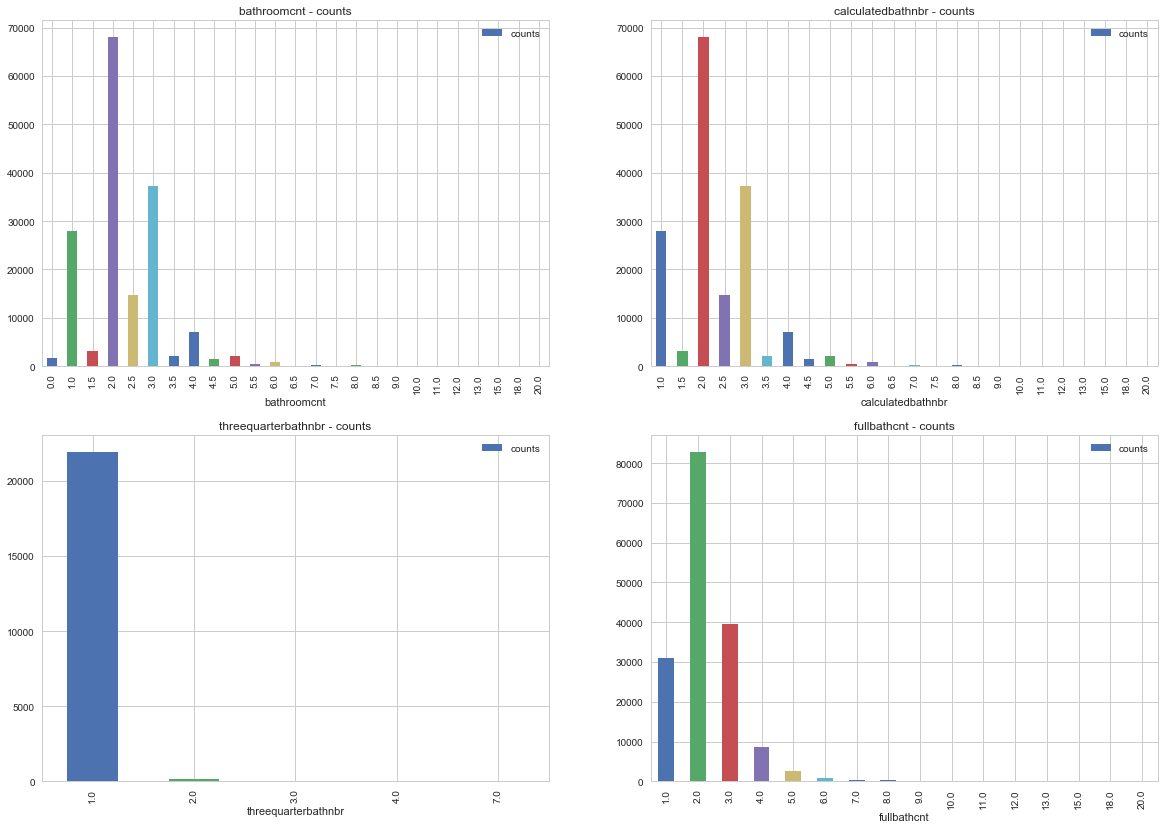

In [63]:
plt.figure(figsize=(20,14))

# Graph for bathroomcnt - counts
ax1 = plt.subplot2grid((2,2), (0,0))
bathroomcnt.plot(x = 'bathroomcnt', y = 'counts', kind = 'bar', ax=ax1)
ax1.set_title('bathroomcnt - counts')

# Graph for calculatedbathnbr - counts
ax2 = plt.subplot2grid((2,2), (0,1))
calculatedbathnbr.plot(x = 'calculatedbathnbr', y = 'counts', kind = 'bar', ax=ax2)
ax2.set_title('calculatedbathnbr - counts')

# Graph for threequarterbathnbr - counts
ax3 = plt.subplot2grid((2,2), (1,0))
threequarterbathnbr.plot(x = 'threequarterbathnbr', y = 'counts', kind = 'bar', ax=ax3)
ax3.set_title('threequarterbathnbr - counts')

# Graph for fullbathcnt - counts
ax4 = plt.subplot2grid((2,2), (1,1))
fullbathcnt.plot(x = 'fullbathcnt', y = 'counts', kind = 'bar', ax=ax4)
ax4.set_title('fullbathcnt - counts')
plt.show()

##### Numberofstories
- 최빈값인 1로 imputation 할 수 있겠음 (보통은 1층집)

In [64]:
numberofstories = pd.DataFrame(merged["numberofstories"])
numberofstories = numberofstories.groupby("numberofstories").size().reset_index(name='counts')

##### roomcnt & bedroomcnt
- roomcnt: Total number of rooms in the principal residence
    - 0이 많다는 점이 특징

In [65]:
roomcnt = pd.DataFrame(merged["roomcnt"])
roomcnt = roomcnt.groupby("roomcnt").size().reset_index(name='counts')

In [66]:
bedroomcnt = pd.DataFrame(merged["bedroomcnt"])
bedroomcnt = bedroomcnt.groupby("bedroomcnt").size().reset_index(name='counts')

In [67]:
# df_rooms = pd.concat([feet_df_desc.loc['roomcnt'], feet_df_desc.loc['bedroomcnt']], axis=1)
# df_rooms
merged_des.loc[["roomcnt", "bedroomcnt"],:]

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
roomcnt,167854,NaN,NaN,NaN,NaN,NaN,1.47748,2.8215,0,0,0,0,18,0.000202516,float64
bedroomcnt,167854,NaN,NaN,NaN,NaN,NaN,3.04174,1.14913,0,2,3,4,16,0.000202516,float64


##### unitcnt
- imputation: 최빈값인 1로 할 수 있겠음 (대부분 집은 1가구)

In [68]:
unitcnt = pd.DataFrame(merged["unitcnt"])
unitcnt = unitcnt.groupby("unitcnt").size().reset_index(name='counts')

##### yearbuilt

In [69]:
yearbuilt = pd.DataFrame(merged["yearbuilt"])
yearbuilt = yearbuilt.groupby("yearbuilt").size().reset_index(name='counts')

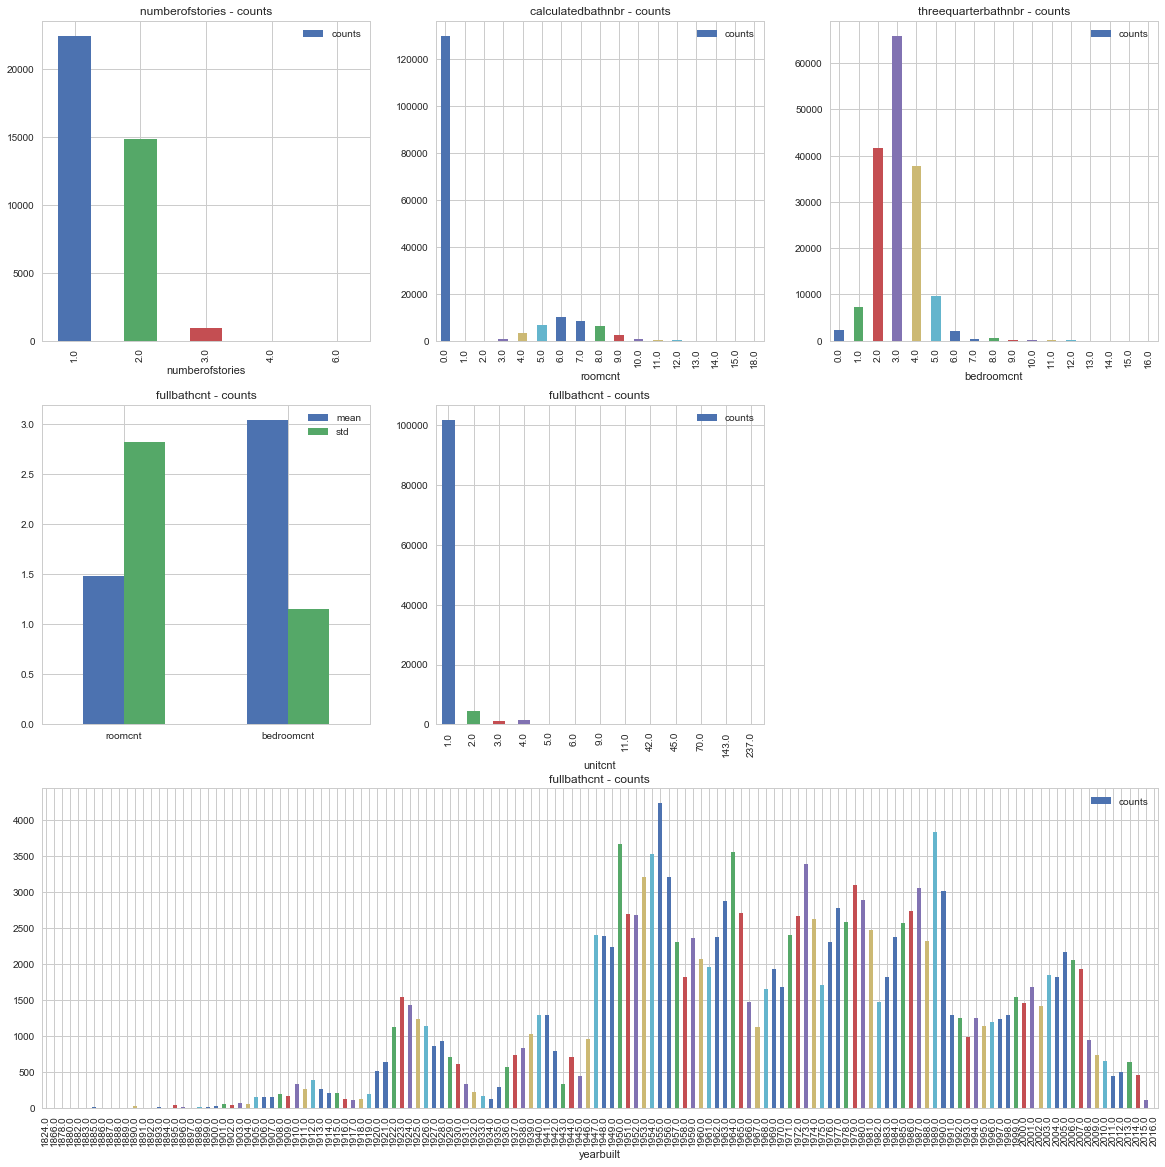

In [70]:
plt.figure(figsize=(20,20))

# Graph for bathroomcnt - counts
ax1 = plt.subplot2grid((3,3), (0,0))
numberofstories.plot(x = 'numberofstories', y = 'counts', kind = 'bar' , ax=ax1)
ax1.set_title('numberofstories - counts')

# Graph for calculatedbathnbr - counts
ax2 = plt.subplot2grid((3,3), (0,1))
roomcnt.plot(x = 'roomcnt', y = 'counts', kind = 'bar', ax=ax2)
ax2.set_title('calculatedbathnbr - counts')

# Graph for threequarterbathnbr - counts
ax3 = plt.subplot2grid((3,3), (0,2))
bedroomcnt.plot(x = 'bedroomcnt', y = 'counts', kind = 'bar', ax=ax3)
ax3.set_title('threequarterbathnbr - counts')

# Graph for fullbathcnt - counts
ax4 = plt.subplot2grid((3,3), (1,0), colspan = 1)
merged_des.loc[["roomcnt", "bedroomcnt"],["mean","std"]].plot.bar(rot=0, ax=ax4)
ax4.set_title('fullbathcnt - counts')

# Graph for fullbathcnt - counts
ax5 = plt.subplot2grid((3,3), (1,1), colspan = 1)
unitcnt.plot(x = 'unitcnt', y = 'counts', kind = 'bar', ax=ax5)
ax5.set_title('fullbathcnt - counts')

# Graph for fullbathcnt - counts
ax6 = plt.subplot2grid((3,3), (2,0), colspan = 3)
yearbuilt.plot(x = 'yearbuilt', y = 'counts', kind = 'bar', ax=ax6)
ax6.set_title('fullbathcnt - counts')

plt.show()

#### **4-2) 집의 기타 특징(유틸리티 등)에 대한 변수들**

In [71]:
merged_des.loc[["heatingorsystemtypeid", "airconditioningtypeid", "hashottuborspa", "fireplacecnt", "fireplaceflag", "poolcnt",
                "poolsizesum", "pooltypeid10", "pooltypeid2", "pooltypeid7"],:]

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
heatingorsystemtypeid,105651,12,2.0,71936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.370705,object
airconditioningtypeid,53788,6,1.0,49854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.67962,object
hashottuborspa,167888,2,False,163984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,bool
fireplacecnt,17896,NaN,NaN,NaN,NaN,NaN,1.18943,0.487327,1,1,1,1,5,0.893405,float64
fireplaceflag,167888,2,False,167494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,bool
poolcnt,34075,NaN,NaN,NaN,NaN,NaN,1,0,1,1,1,1,1,0.797037,float64
poolsizesum,1838,NaN,NaN,NaN,NaN,NaN,518.931,155.733,24,420,500,600,1750,0.989052,float64
pooltypeid10,167888,2,False,166262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,bool
pooltypeid2,167888,2,False,165610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,bool
pooltypeid7,167888,2,False,136112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,bool


- missing value ratio가 높은 변수들이 많음
- pool 관련 변수, fireplace, hot tub or spa는 NaN 값은 없는 경우로 보아 0으로 imputation
- heating system, airconditioning type은 imputation이 애매한 경우

##### heatingorsystemtypeid & airconditioningtypeid
- 난방과 에어컨 타입에 대한 카테고리 변수
- 난방: 2-Central, 7-Floor/Wall, 13-None, 24-Yes
    - class에 none과 yes도 있음으로 미루어 NaN값의 분포도 유사할 것이라고 추측, 최빈값인 2로 imputation 가능
    - 혹은 13과 NaN을 0으로, 나머지는 1로 하여 heating_flag 같은 변수로 만들 수 있음
- 에어컨: 1-Central, 5-None, 11-Wall unit, 13-Yes
    - class에 none과 yes도 있음으로 미루어 NaN값의 분포도 유사할 것이라고 추측, 최빈값인 1로 imputation 가능
    - 혹은 5과 NaN을 0으로, 나머지는 1로 하여 aircond_flag 같은 변수로 만들 수 있음
- 하지만 난방의 37%와 에어컨의 68%를 '없다'고 가정하는 것은 무리가 있어 보임

In [72]:
heatingorsystemtypeid = pd.DataFrame(merged["heatingorsystemtypeid"])
heatingorsystemtypeid = heatingorsystemtypeid.groupby("heatingorsystemtypeid").size().reset_index(name='counts')

In [73]:
airconditioningtypeid = pd.DataFrame(merged["airconditioningtypeid"])
airconditioningtypeid = airconditioningtypeid.groupby("airconditioningtypeid").size().reset_index(name='counts')

##### fireplacecnt & fireplaceflag
- NaN값은 없는 경우라고 간주, 0으로 imputation

In [74]:
fireplacecnt = pd.DataFrame(merged["fireplacecnt"])
fireplacecnt = fireplacecnt.groupby("fireplacecnt").size().reset_index(name='counts')

In [75]:
fireplaceflag = pd.DataFrame(merged["fireplaceflag"])
fireplaceflag = fireplaceflag.groupby("fireplaceflag").size().reset_index(name='counts')
fireplaceflag

,fireplaceflag,counts
0,False,167494
1,True,394


##### pool 관련 변수들
- poolcnt, poolsizesum, pooltypeid10, pooltypeid2, pooltypeid7, hashottuborspa
- 이 변수들은 NaN 값을 없는 경우로 간주, 0으로 imputation

In [76]:
# poolcnt: pool의 개수
pd.DataFrame(merged['poolcnt'].value_counts().sort_index())

,poolcnt
1.0,34075


In [77]:
# hashottuborspa: Does the home have a hot tub or spa
pd.DataFrame(merged['hashottuborspa'].value_counts().sort_index())

,hashottuborspa
False,163984
True,3904


In [78]:
# pooltypeid10: Spa or Hot Tub
pd.DataFrame(merged['pooltypeid10'].value_counts().sort_index())

,pooltypeid10
False,166262
True,1626


In [79]:
# pooltypeid7: Pool without hot tub
pd.DataFrame(merged['pooltypeid2'].value_counts().sort_index())

,pooltypeid2
False,165610
True,2278


In [80]:
pd.DataFrame(merged['pooltypeid7'].value_counts().sort_index())

,pooltypeid7
False,136112
True,31776


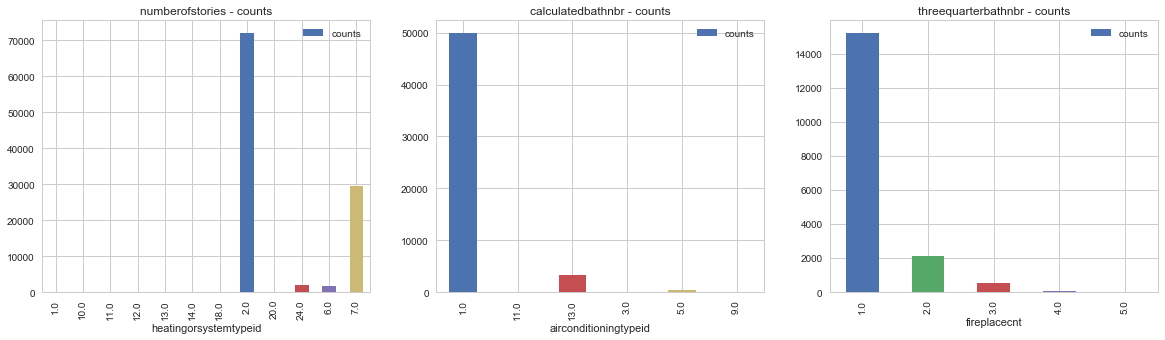

In [81]:
plt.figure(figsize=(20,5))

# Graph for bathroomcnt - counts
ax1 = plt.subplot2grid((1,3), (0,0))
heatingorsystemtypeid.plot(x = 'heatingorsystemtypeid', y = 'counts', kind = 'bar', ax=ax1)
ax1.set_title('numberofstories - counts')

# Graph for calculatedbathnbr - counts
ax2 = plt.subplot2grid((1,3), (0,1))
airconditioningtypeid.plot(x = 'airconditioningtypeid', y = 'counts', kind = 'bar', ax=ax2)
ax2.set_title('calculatedbathnbr - counts')

# Graph for threequarterbathnbr - counts
ax3 = plt.subplot2grid((1,3), (0,2))
fireplacecnt.plot(x = 'fireplacecnt', y = 'counts', kind = 'bar', ax=ax3)
ax3.set_title('threequarterbathnbr - counts')

plt.show()

#### **4-3) 집의 면적에 대한 변수들**
- basementsqft, finishedfloor1squarefeet, calculatedfinishedsquarefeet, finishedsquarefeet6, finishedsquarefeet12, finishedsquarefeet13, finishedsquarefeet15, finishedsquarefeet50, yardbuildingsqft17, yardbuildingsqft26, garagecarcnt, garagetotalsqft, lotsizesquarefeet

In [82]:
merged_des.loc[["basementsqft", "calculatedfinishedsquarefeet", "finishedfloor1squarefeet", "finishedsquarefeet6",
                "finishedsquarefeet12", "finishedsquarefeet13","finishedsquarefeet15","finishedsquarefeet50",
                "yardbuildingsqft17","yardbuildingsqft26","garagecarcnt","garagetotalsqft", "lotsizesquarefeet"],
               ["count", "mean", "std", "min", "25%", "50%", "75%", "max", "missing_ratio", "dtype"]]

,count,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
basementsqft,93,695.376,583.952,38,280,588,819,3560,0.999446,float64
calculatedfinishedsquarefeet,166992,1778.63,940.356,2,1183,1541,2103,35640,0.00533689,float64
finishedfloor1squarefeet,12893,1356.49,661.069,44,945,1252,1615,7625,0.923205,float64
finishedsquarefeet6,807,2197.29,1300.55,257,1057,1886,3240,7224,0.995193,float64
finishedsquarefeet12,159519,1752.33,921.361,2,1172,1520,2065,21929,0.0498487,float64
finishedsquarefeet13,75,1395.71,116.539,1056,1344,1440,1440,1584,0.999553,float64
finishedsquarefeet15,6591,2368.33,1124.3,560,1634,2099,2845,35640,0.960742,float64
finishedsquarefeet50,12893,1367.65,698.669,44,945,1252,1619,12467,0.923205,float64
yardbuildingsqft17,5039,307.919,227.431,11,175,252,375,3191,0.969986,float64
yardbuildingsqft26,165,271.261,293.611,12,88,160,320,1366,0.999017,float64


- **1. basementsqft** : Finished living area below or partially below ground level(지면보다 낮거나 부분적으로 낮은 부분)
- **2. calculatedfinishedsquarefeet** : Calculated total finished living area of the home(가정의 (마감)완료된 총 거주 면적)   
- **3. finishedfloor1squarefeet** : Size of the finished living area on the first (entry) floor of the home (주택 1층 생활 공간의 규모)
- **4. finishedsquarefeet6** : Base unfinished and finished area (기본 완료 및 완료되지 않은 영역)
- **5. finishedsquarefeet12** : Finished living area ((마감)완료된 생활 공간)
- **6. finishedsquarefeet13** : Perimeter  living area
- **7. finishedsquarefeet15** : Total area (총 면적)
- **8. finishedsquarefeet50** : Size of the finished living area on the first (entry) floor of the home (주택 1층 생활 공간의 규모)
- **9. yardbuildingsqft17** : Patio in  yard (마당의 파티오(보통 집 뒤쪽에 만드는 테라스))
- **10. yardbuildingsqft26** : Storage shed/building in yard (마당의 저장 창고)
- **11. garagecarcnt** : Total number of garages on the lot including an attached garage (부착된 차고를 포함한 부지의 총 차고 수)
- **12. garagetotalsqft** :  Total number of square feet of all garages on lot including an attached garage (부착된 차고를 포함하여 부지에있는 모든 차고의 총 평방 피트)
- **13. lotsizesquarefeet** : Area of the lot in square feet (부지의 평방 피트 면적)

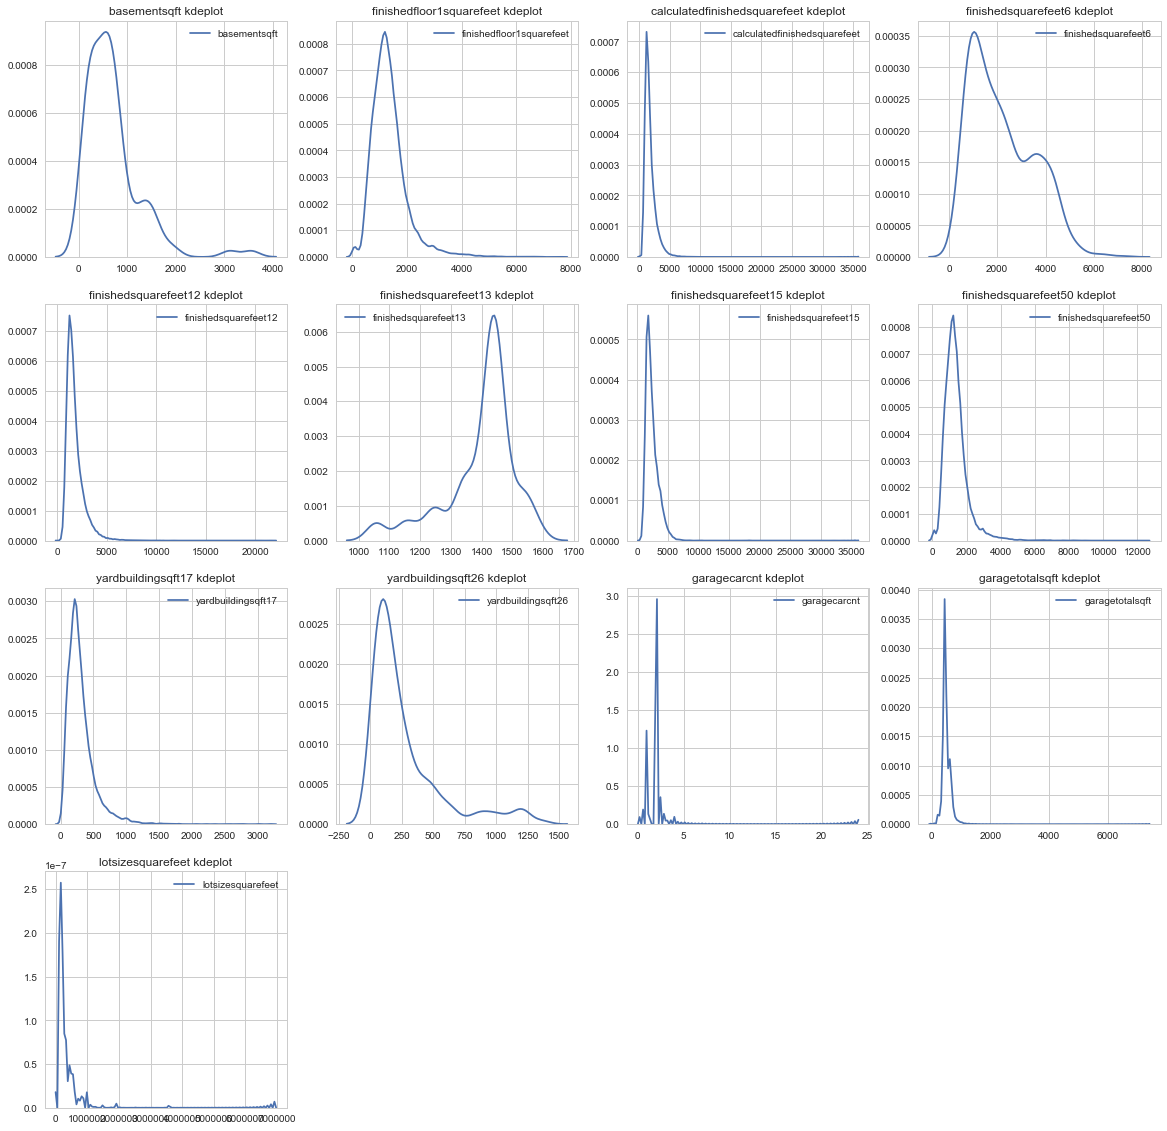

In [83]:
plt.figure(figsize=(20,20))

# Graph for basementsqft kdeplot
ax1 = plt.subplot2grid((4,4), (0,0))
sns.kdeplot(merged['basementsqft'], ax=ax1)
ax1.set_title('basementsqft kdeplot')

# Graph for finishedfloor1squarefeet kdeplot
ax2 = plt.subplot2grid((4,4), (0,1))
sns.kdeplot(merged['finishedfloor1squarefeet'],ax=ax2)
ax2.set_title('finishedfloor1squarefeet kdeplot')

# Graph for calculatedfinishedsquarefeet kdeplot
ax3 = plt.subplot2grid((4,4), (0,2))
sns.kdeplot(merged['calculatedfinishedsquarefeet'],ax=ax3)
ax3.set_title('calculatedfinishedsquarefeet kdeplot')

# Graph for finishedsquarefeet6 kdeplot
ax4 = plt.subplot2grid((4,4), (0,3))
sns.kdeplot(merged['finishedsquarefeet6'],ax=ax4)
ax4.set_title('finishedsquarefeet6 kdeplot')

# Graph for finishedsquarefeet12 kdeplot
ax5 = plt.subplot2grid((4,4), (1,0))
sns.kdeplot(merged['finishedsquarefeet12'],ax=ax5)
ax5.set_title('finishedsquarefeet12 kdeplot')

# Graph for finishedsquarefeet13 kdeplot
ax6 = plt.subplot2grid((4,4), (1,1))
sns.kdeplot(merged['finishedsquarefeet13'],ax=ax6)
ax6.set_title('finishedsquarefeet13 kdeplot')

# Graph for finishedsquarefeet15 kdeplot
ax7 = plt.subplot2grid((4,4), (1,2))
sns.kdeplot(merged['finishedsquarefeet15'],ax=ax7)
ax7.set_title('finishedsquarefeet15 kdeplot')

# Graph for finishedsquarefeet50 kdeplot
ax8 = plt.subplot2grid((4,4), (1,3))
sns.kdeplot(merged['finishedsquarefeet50'],ax=ax8)
ax8.set_title('finishedsquarefeet50 kdeplot')

# Graph for yardbuildingsqft17 kdeplot
ax9 = plt.subplot2grid((4,4), (2,0))
sns.kdeplot(merged['yardbuildingsqft17'],ax=ax9)
ax9.set_title('yardbuildingsqft17 kdeplot')

# Graph for yardbuildingsqft26 kdeplot
ax10 = plt.subplot2grid((4,4), (2,1))
sns.kdeplot(merged['yardbuildingsqft26'], ax=ax10)
ax10.set_title('yardbuildingsqft26 kdeplot')

# Graph for garagecarcnt kdeplot
ax11 = plt.subplot2grid((4,4), (2,2))
sns.kdeplot(merged['garagecarcnt'], ax=ax11)
ax11.set_title('garagecarcnt kdeplot')

# Graph for garagetotalsqft kdeplot
ax12 = plt.subplot2grid((4,4), (2,3))
sns.kdeplot(merged['garagetotalsqft'], ax=ax12)
ax12.set_title('garagetotalsqft kdeplot')

# Graph for lotsizesquarefeet kdeplot
ax13 = plt.subplot2grid((4,4), (3,0))
sns.kdeplot(merged['lotsizesquarefeet'], ax=ax13)
ax13.set_title('lotsizesquarefeet kdeplot')

plt.show()

##### 5) tax와 관련된 변수들 (total 7)
- numerical variables: taxvaluedollarcnt, structuretaxvaluedollarcnt, landtaxvaluedollarcnt, taxamount, taxdelinquencyyear_past<br/>
- categorical variables: assessmentyear, taxdelinquencyflag, taxdelinquencyyear

In [84]:
merged_des.loc[["taxvaluedollarcnt", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt","taxamount",
                "assessmentyear", "taxdelinquencyflag", "taxdelinquencyyear"],:]

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
taxvaluedollarcnt,167852,NaN,NaN,NaN,NaN,NaN,472683,602837,22,202652,350000,554002,4.90612e+07,0.000214429,float64
structuretaxvaluedollarcnt,167359,NaN,NaN,NaN,NaN,NaN,184346,219284,44,82568,134051,214257,1.14218e+07,0.00315091,float64
landtaxvaluedollarcnt,167851,NaN,NaN,NaN,NaN,NaN,288880,445645,22,83730,197776,355334,4.89522e+07,0.000220385,float64
taxamount,167843,NaN,NaN,NaN,NaN,NaN,5989.52,7214.73,19.92,2798.07,4501.04,6914.16,586639,0.000268036,float64
assessmentyear,167854,NaN,NaN,NaN,NaN,NaN,2015.46,0.498569,2015,2015,2015,2016,2016,0.000202516,float64
taxdelinquencyflag,167888,2,False,163205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,bool
taxdelinquencyyear,4683,NaN,NaN,NaN,NaN,NaN,2013.78,1.69046,1999,2013,2014,2015,2015,0.972106,float64


- **1. taxvaluedollarcnt** : The total tax assessed value of the parcel (토지(땅의 구획)의 총 세금 평가 가치)
- **2. structuretaxvaluedollarcnt** : The assessed value of the built structure on the parcel (건설된 구조물에 대한 토지(땅의 구획)의 평가 값)
- **3. landtaxvaluedollarcnt** : The assessed value of the land area of the parcel (토지(땅의 구획)의 토지 면적에 대한 평가 값)
- **4. taxamount** : The total property tax assessed for that assessment year (해당 과세 연도에 대해 평가된 총 재산세)

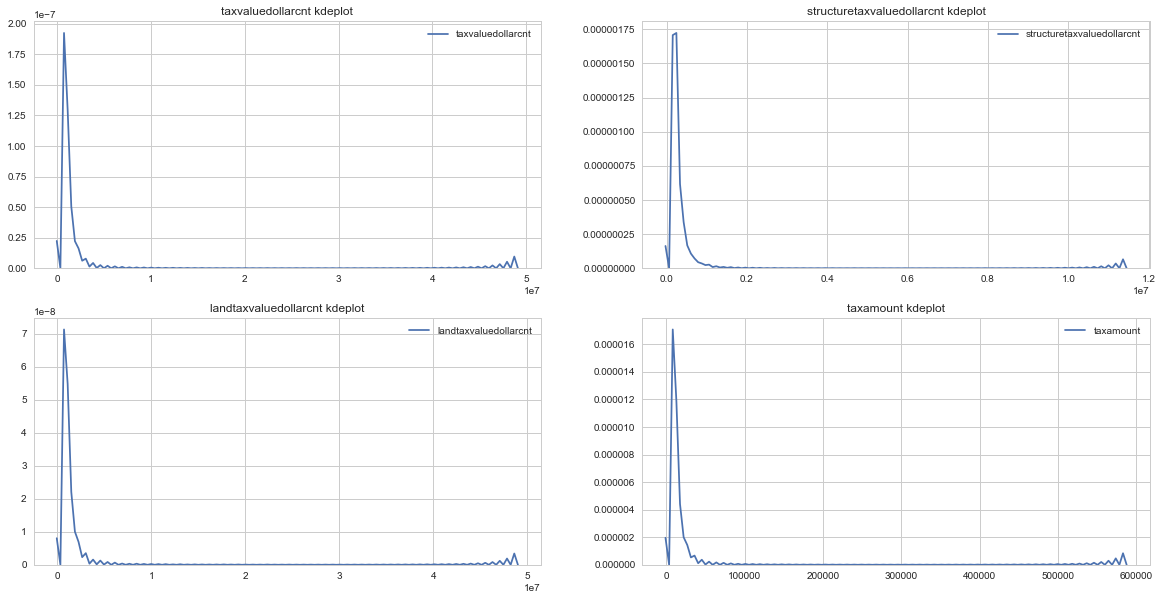

In [85]:
plt.figure(figsize=(20,10))

# Graph for taxvaluedollarcnt kdeplot
ax1 = plt.subplot2grid((2,2), (0,0))
sns.kdeplot(merged['taxvaluedollarcnt'], ax=ax1)
ax1.set_title('taxvaluedollarcnt kdeplot')

# Graph for structuretaxvaluedollarcnt kdeplot
ax2 = plt.subplot2grid((2,2), (0,1))
sns.kdeplot(merged['structuretaxvaluedollarcnt'],ax=ax2)
ax2.set_title('structuretaxvaluedollarcnt kdeplot')

# Graph for landtaxvaluedollarcnt kdeplot
ax3 = plt.subplot2grid((2,2), (1,0))
sns.kdeplot(merged['landtaxvaluedollarcnt'],ax=ax3)
ax3.set_title('landtaxvaluedollarcnt kdeplot')

# Graph for taxamount kdeplot
ax4 = plt.subplot2grid((2,2), (1,1))
sns.kdeplot(merged['taxamount'],ax=ax4)
ax4.set_title('taxamount kdeplot')

plt.show()

- **5. assessmentyear** : The year of the property tax assessment (재산세 평가 년도)
- **6. taxdelinquencyflag** : 재산세 미납 여부 → NaN값은 미납되지 않았다고 간주, 0으로 imputation
- **7. taxdelinquencyyear** : Year for which the unpaid propert taxes were due (미납 된 재산세 (예정이었던) 납부시기)
- **8. taxdelinquencyyear_past** : 세금미납이 몇년 전에 있었는지 계산해서 실수변수를 새로이 추가함

In [34]:
assessmentyear = merged.groupby("assessmentyear").size().reset_index(name='count')
taxdelinquencyflag = merged.groupby("taxdelinquencyflag").size().reset_index(name='count')
taxdelinquencyyear = merged.groupby("taxdelinquencyyear").size().reset_index(name='count')
merged["taxdelinquencyyear_past"] = merged["transaction_year"] - merged["taxdelinquencyyear"]
taxdelinquencyyear_past = merged.groupby("taxdelinquencyyear_past").size().reset_index(name='count')

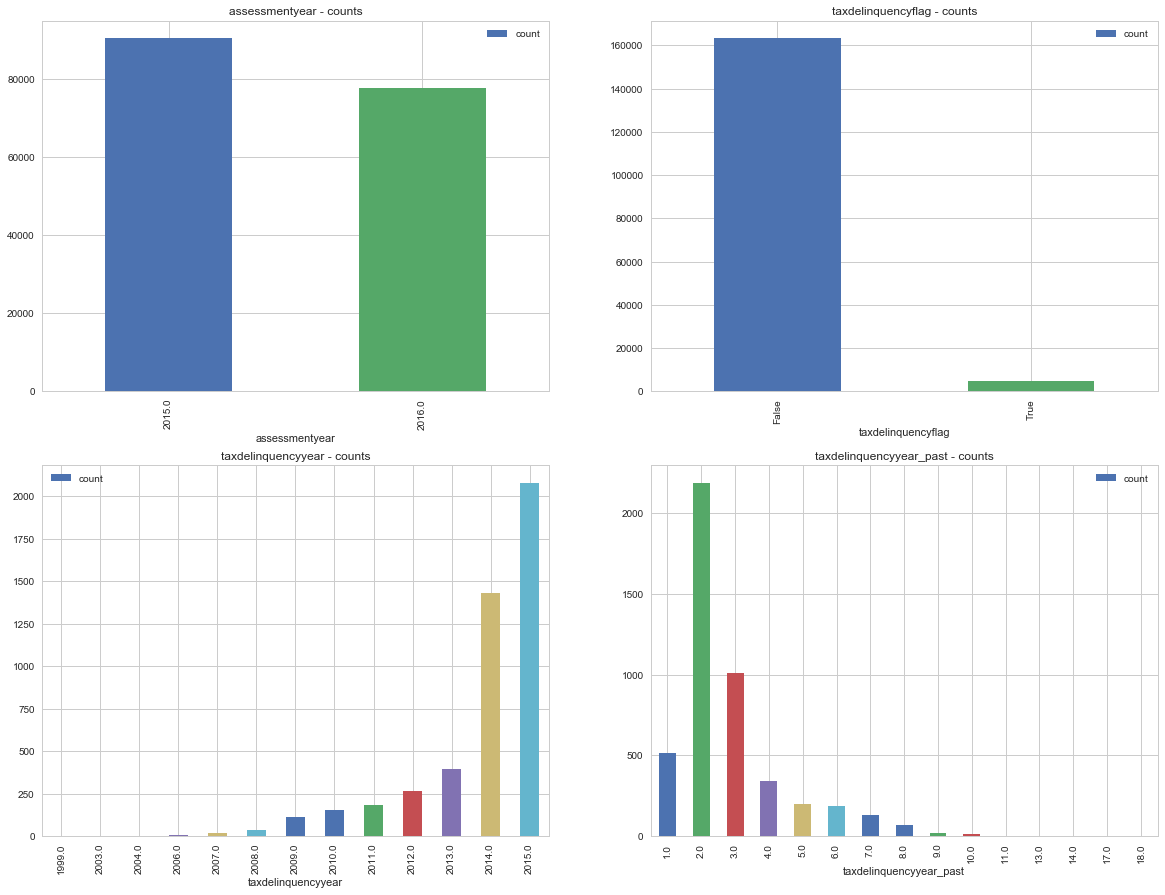

In [87]:
plt.figure(figsize=(20,15))

# Graph for assessmentyear - counts
ax1 = plt.subplot2grid((2,2), (0,0))
assessmentyear.plot(x = 'assessmentyear', y = 'count', kind = 'bar', ax=ax1)
ax1.set_title('assessmentyear - counts')

# Graph for taxdelinquencyflag - counts
ax2 = plt.subplot2grid((2,2), (0,1))
taxdelinquencyflag.plot(x = 'taxdelinquencyflag', y = 'count', kind = 'bar', ax=ax2)
ax2.set_title('taxdelinquencyflag - counts')

# Graph for taxdelinquencyyear - counts
ax3 = plt.subplot2grid((2,2), (1,0))
taxdelinquencyyear.plot(x = 'taxdelinquencyyear', y = 'count', kind = 'bar', ax=ax3)
ax3.set_title('taxdelinquencyyear - counts')

# Graph for taxdelinquencyyear_past - counts
ax4 = plt.subplot2grid((2,2), (1,1))
taxdelinquencyyear_past.plot(x = 'taxdelinquencyyear_past', y = 'count', kind = 'bar', ax=ax4)
ax4.set_title('taxdelinquencyyear_past - counts')

plt.show()

### 2.4 Relationship between Logerror and variables

#### **1) 집의 지리정보와 관련된 변수**
- numerical variable: latitude, longitude
- categorical variable: fips, census_3, census_4, raw_census_3, raw_census_4, regionidcounty, regionidcity, regionidzip, regionidneighborhood

##### 위도 경도와 logerror

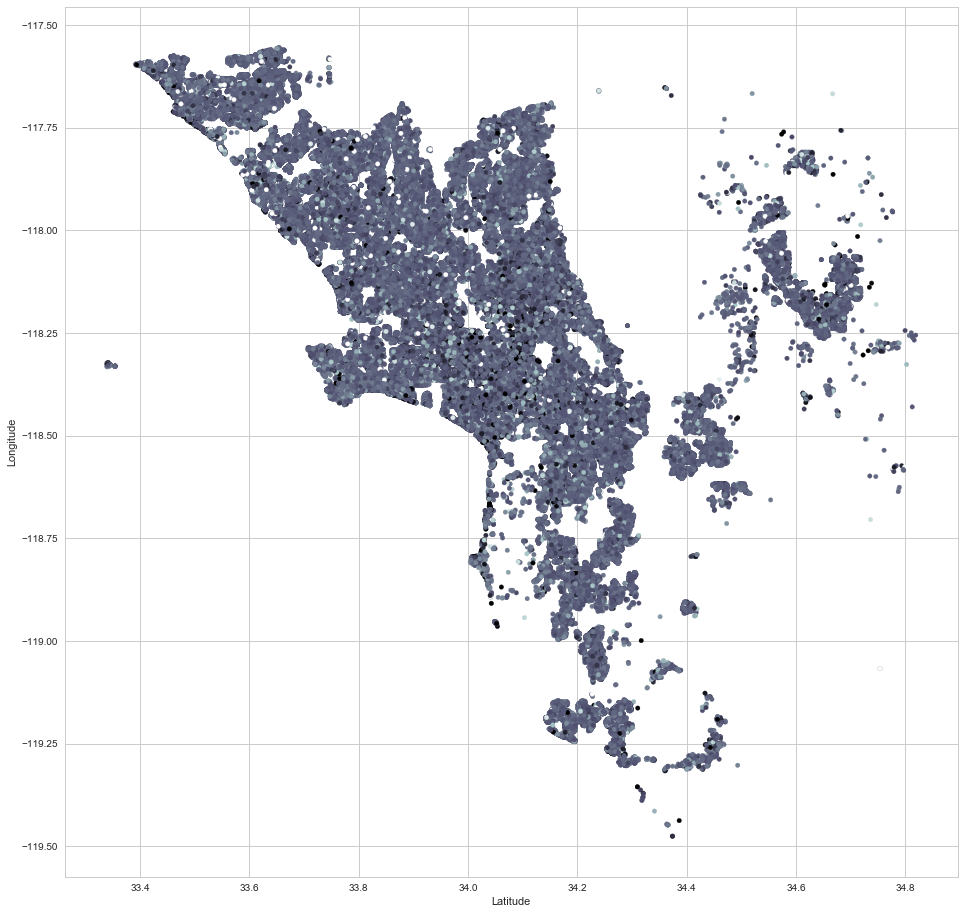

In [88]:
# 위도 경도에 따른 logerror: logerror가 크면 밝은 색, 작으면 어두운 색
plt.figure(figsize=(16,16))
plt.scatter(x=merged.latitude.values, y=merged.longitude.values, c=merged.logerror.values, cmap=mpl.cm.bone, s=20)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

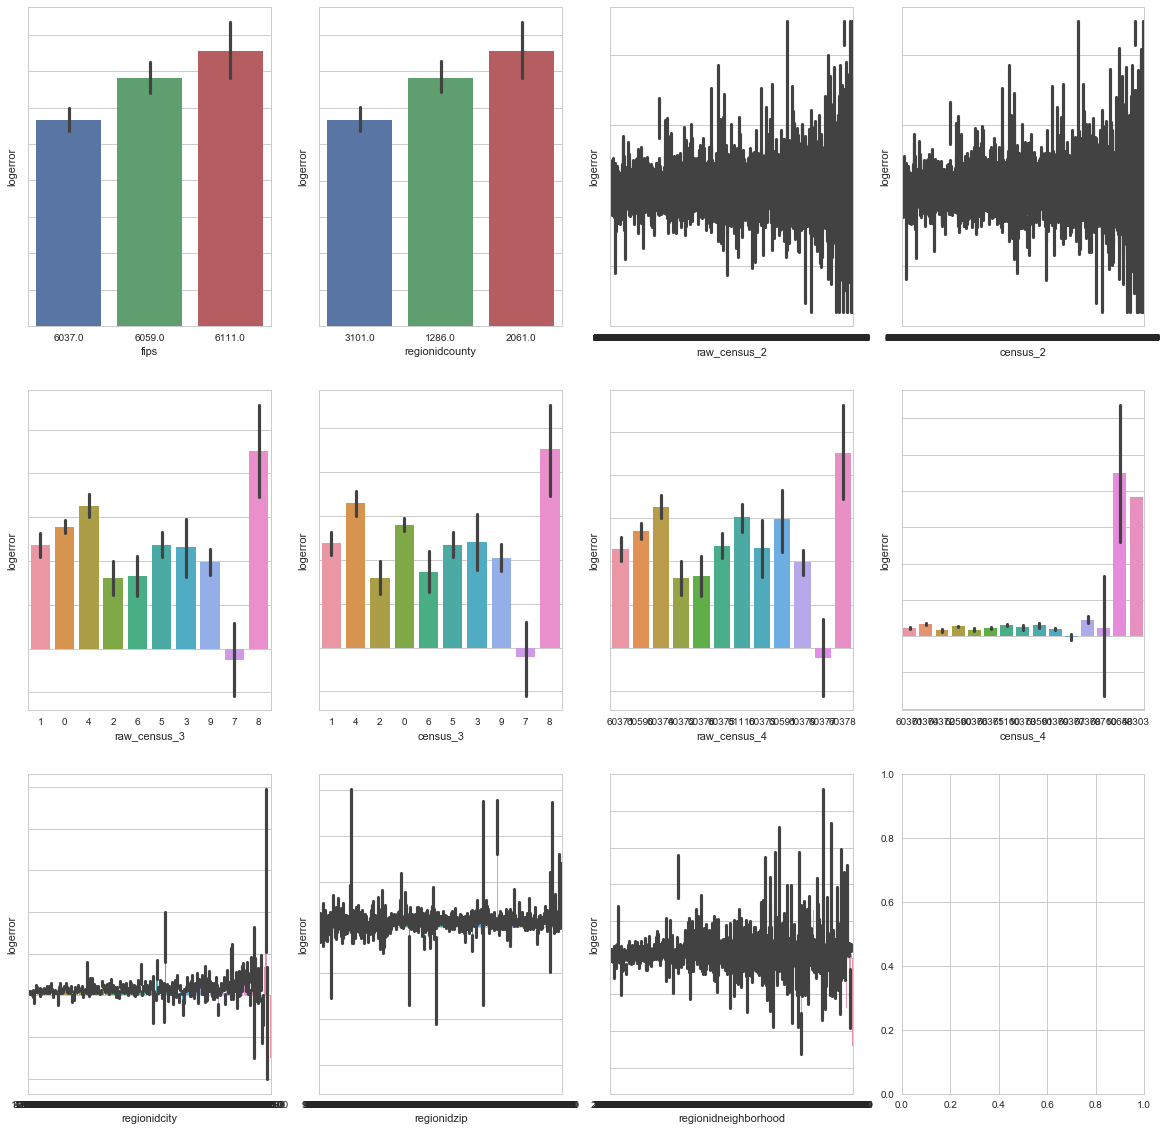

In [89]:
geo_cat = ["fips", "regionidcounty", "raw_census_2", "census_2",
           "raw_census_3", "census_3", "raw_census_4", "census_4",
           "regionidcity", "regionidzip", "regionidneighborhood"]

fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(geo_cat):
    sns.barplot(x = n, y='logerror', data = merged, ax = ax[idx//4, idx % 4])
    ax[idx// 4, idx % 4].set(yticklabels=[])
    
    continue

#### **2) 건물 특징, 타입 등에 대한 변수**

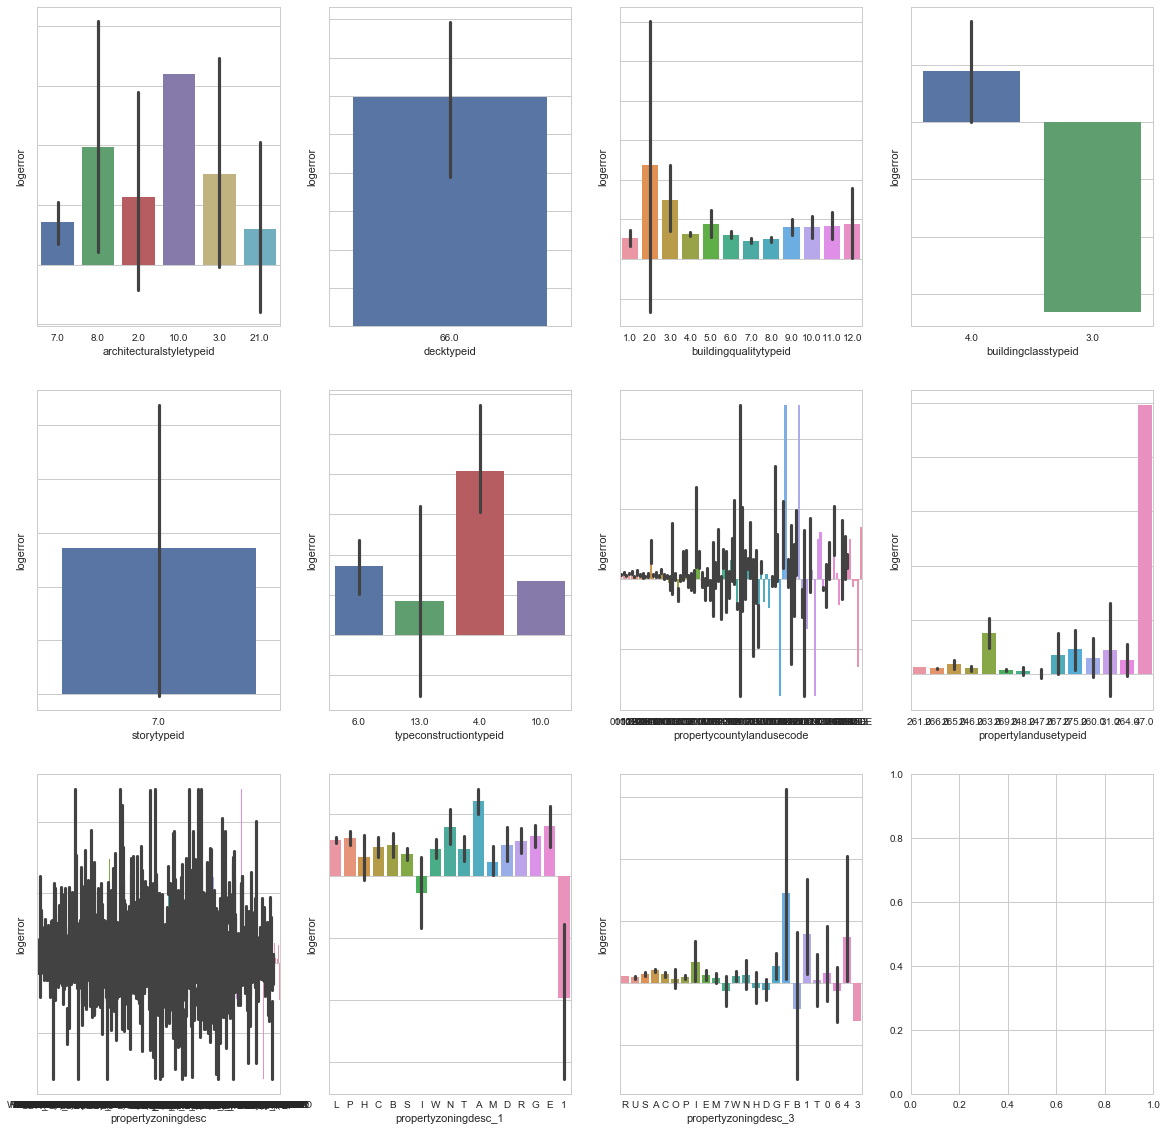

In [90]:
bdg_cat =  ["architecturalstyletypeid", "decktypeid", "buildingqualitytypeid", "buildingclasstypeid", 
            "storytypeid", "typeconstructiontypeid", "propertycountylandusecode", "propertylandusetypeid",
            "propertyzoningdesc", "propertyzoningdesc_1", "propertyzoningdesc_3"]

fig, ax = plt.subplots(3, 4, figsize = (20, 20))

for idx, n in enumerate(bdg_cat):
    sns.barplot(x = n, y='logerror', data = merged, ax = ax[idx // 4, idx % 4])
    ax[idx // 4, idx % 4].set(yticklabels=[])
    
    continue

#### **3) 집의 구조, 면적 등에 관련된 변수 **

##### **(1) 집의 면적에 대한 변수**

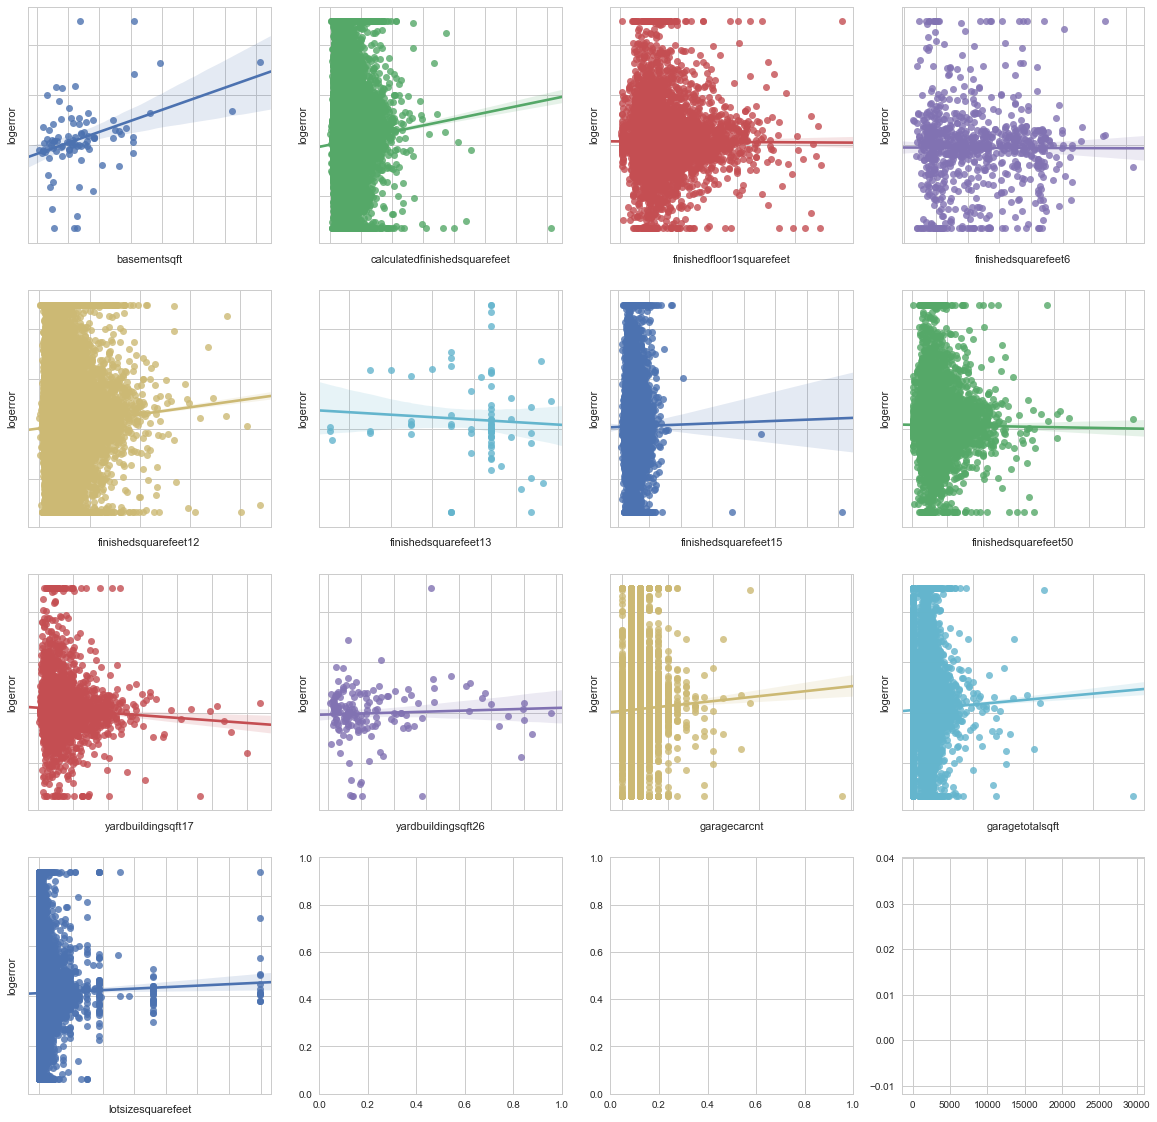

In [91]:
sqft_vars = ["basementsqft", "calculatedfinishedsquarefeet", "finishedfloor1squarefeet", "finishedsquarefeet6",
           "finishedsquarefeet12", "finishedsquarefeet13", "finishedsquarefeet15", "finishedsquarefeet50", "yardbuildingsqft17",
           "yardbuildingsqft26", "garagecarcnt", "garagetotalsqft", "lotsizesquarefeet"]

fig, ax = plt.subplots(4,4, figsize = (20,20))

for idx, n in enumerate(sqft_vars):
    if n == 'logerror':
        continue
    sns.regplot(x=n, y='logerror', data=merged, ax = ax[idx//4,idx%4])
    ax[idx//4, idx%4].set(yticklabels=[])
    ax[idx//4, idx%4].set(xticklabels=[])
    continue

##### (2) 집의 구조에 관련된 실수 변수

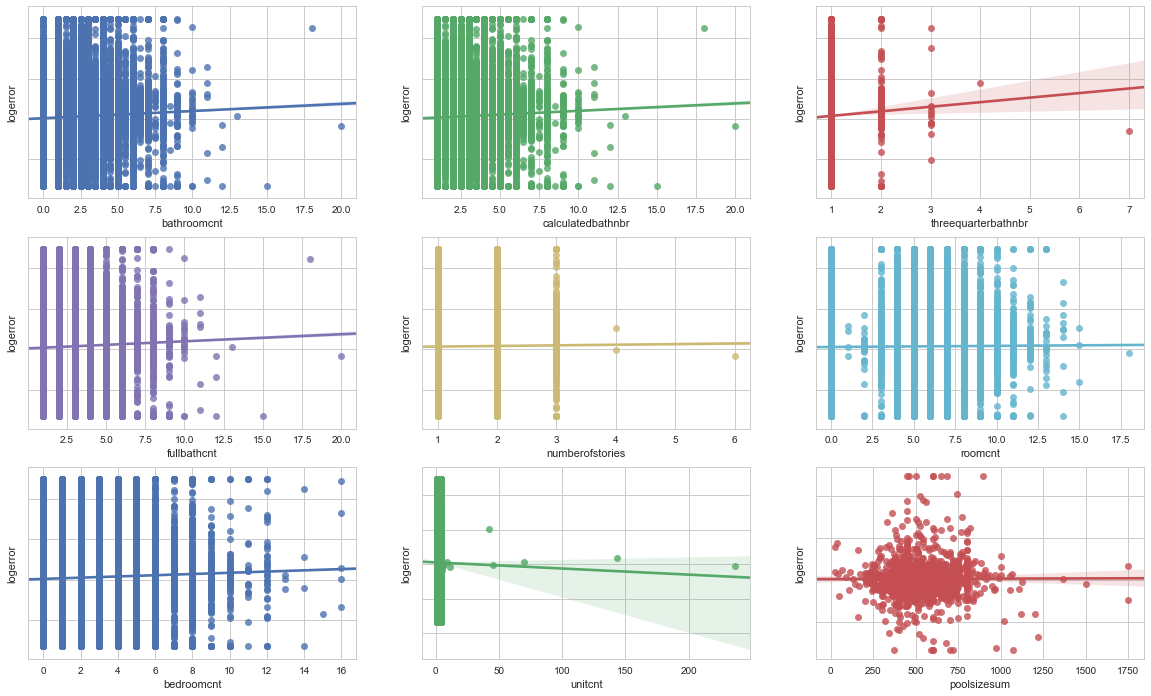

In [92]:
strt_var = ["bathroomcnt", "calculatedbathnbr", "threequarterbathnbr", "fullbathcnt",
            "numberofstories", "roomcnt", "bedroomcnt", "unitcnt", "poolsizesum"]

fig, ax = plt.subplots(3,3, figsize = (20,12))

for idx, n in enumerate(strt_var):
    sns.regplot(x=n, y='logerror', data=merged, ax = ax[idx // 3,idx % 3])
    ax[idx // 3, idx % 3].set(yticklabels=[])
    continue

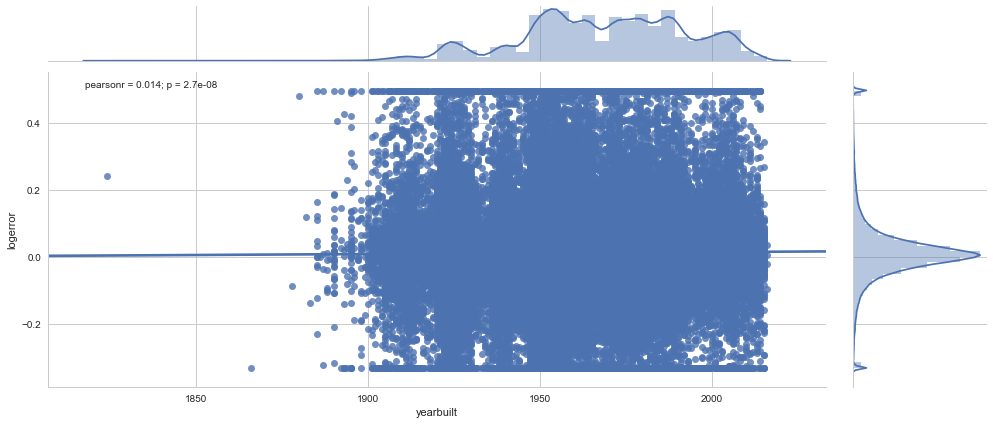

In [93]:
yearbuilt_plot = sns.jointplot(x = "yearbuilt", y = "logerror", data=merged, kind="reg")
yearbuilt_plot.fig.set_size_inches(15,6)

##### **(3) 집의 기타 특징에 관한 변수들**

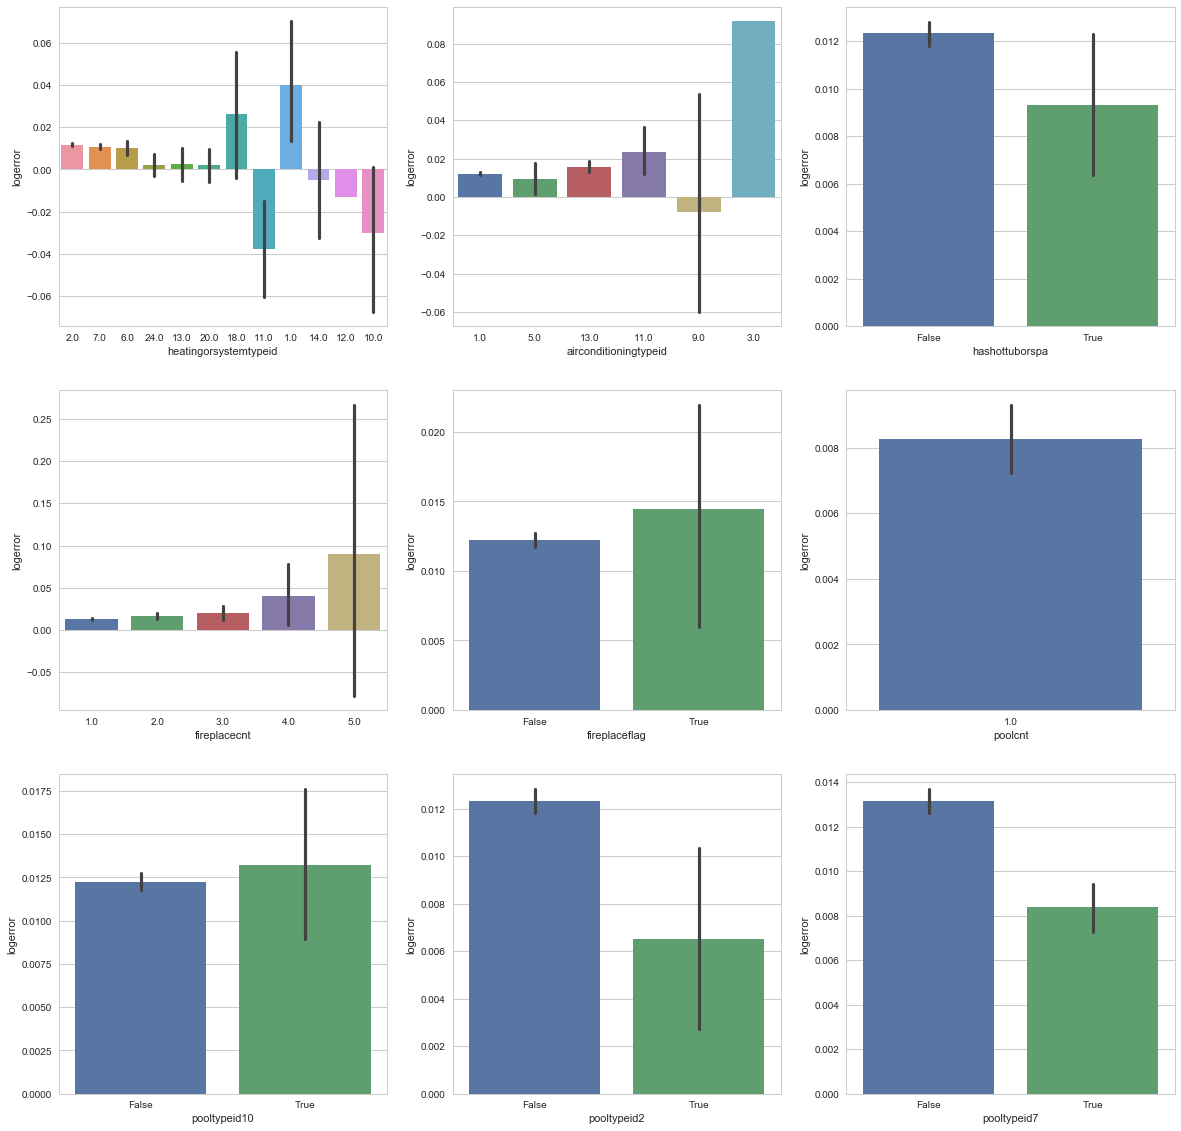

In [94]:
plt.figure(figsize=(20, 20))

ax1 = plt.subplot(3, 3, 1)
sns.barplot(x = 'heatingorsystemtypeid', y='logerror', data = merged, ax = ax1)

ax2 = plt.subplot(3, 3, 2)
sns.barplot(x = 'airconditioningtypeid', y='logerror', data = merged, ax = ax2)

ax3 = plt.subplot(3, 3, 3)
sns.barplot(x = 'hashottuborspa', y='logerror', data = merged, ax = ax3)

ax4 = plt.subplot(3, 3, 4)
sns.barplot(x = 'fireplacecnt', y='logerror', data = merged, ax = ax4)

ax5 = plt.subplot(3, 3, 5)
sns.barplot(x = 'fireplaceflag', y='logerror', data = merged, ax = ax5)

ax6 = plt.subplot(3, 3, 6)
sns.barplot(x = 'poolcnt', y='logerror', data = merged, ax = ax6)

ax7 = plt.subplot(3, 3, 7)
sns.barplot(x = 'pooltypeid10', y='logerror', data = merged, ax = ax7)

ax8 = plt.subplot(3, 3, 8)
sns.barplot(x = 'pooltypeid2', y='logerror', data = merged, ax = ax8)

ax9 = plt.subplot(3, 3, 9)
sns.barplot(x = 'pooltypeid7', y='logerror', data = merged, ax = ax9)

plt.show()

#### **4) tax와 관련된 변수**

##### tax 관련 numerical variable과 loggerror의 관계

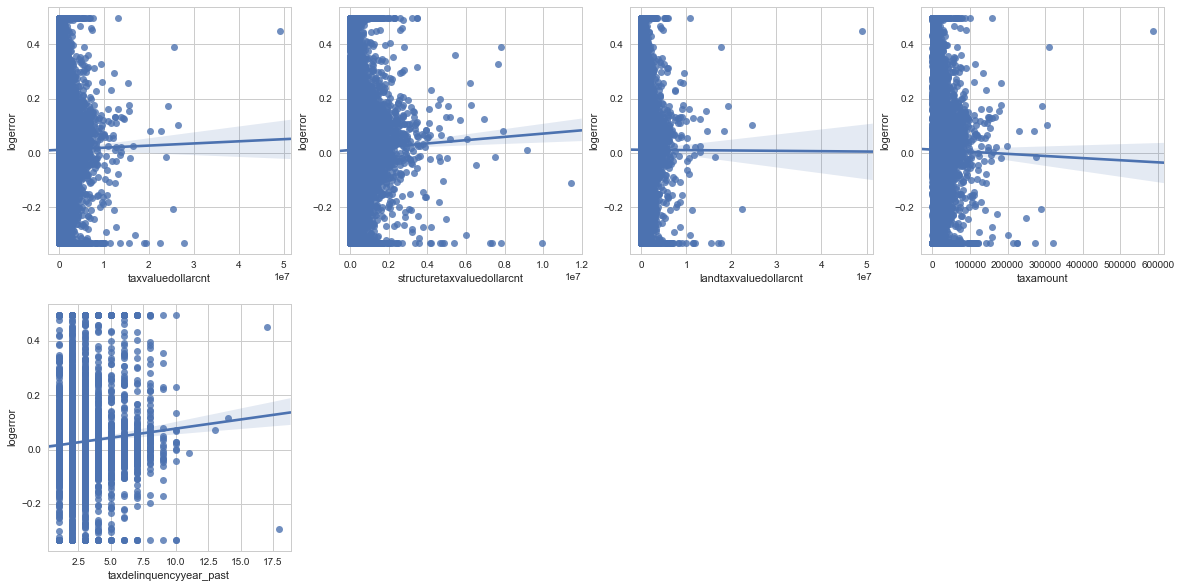

In [95]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(2, 4, 1)
sns.regplot(x="taxvaluedollarcnt", y='logerror', data=merged, ax = ax1)

ax2 = plt.subplot(2, 4, 2)
sns.regplot(x="structuretaxvaluedollarcnt", y='logerror', data=merged, ax = ax2)

ax3 = plt.subplot(2, 4, 3)
sns.regplot(x="landtaxvaluedollarcnt", y='logerror', data=merged, ax = ax3)

ax4 = plt.subplot(2, 4, 4)
sns.regplot(x="taxamount", y='logerror', data=merged, ax = ax4)

ax5 = plt.subplot(2, 4, 5)
sns.regplot(x='taxdelinquencyyear_past', y='logerror', data=merged, ax = ax5)

plt.show()

##### tax 관련 categorical variable과 loggerror의 관계

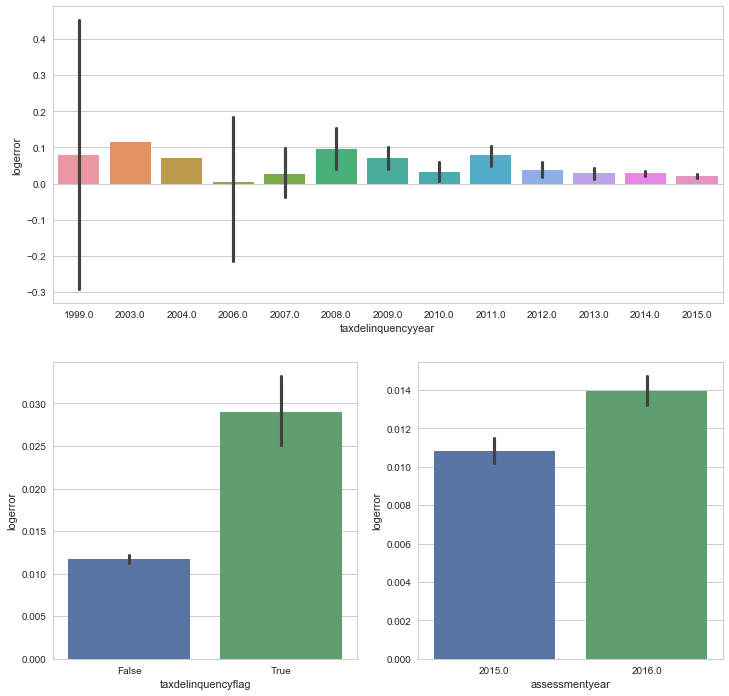

In [96]:
plt.figure(figsize=(12, 12))
ax1 = plt.subplot(2, 1, 1)
sns.barplot(x = 'taxdelinquencyyear', y='logerror', data = merged.sort_values(by='taxdelinquencyyear'), ax = ax1)

ax2 = plt.subplot2grid((2,2), (1,0))
sns.barplot(x = 'taxdelinquencyflag', y='logerror', data = merged, ax = ax2)

ax3 = plt.subplot2grid((2,2), (1,1))
sns.barplot(x = 'assessmentyear', y='logerror', data = merged, ax = ax3)

plt.show()

# **3. Feature Engineering**

## 3.1 Missing Values

### 3.1.1 Status of missing values
- 데이터에 missing value가 상당히 많음, missing value의 비중을 높은 순으로 살펴보자

In [97]:
merged_missing = pd.DataFrame(merged_des["missing_ratio"].sort_values(ascending=False))
merged_missing.reset_index()

,index,missing_ratio
0,buildingclasstypeid,0.999815
1,finishedsquarefeet13,0.999553
2,storytypeid,0.999446
3,basementsqft,0.999446
4,yardbuildingsqft26,0.999017
5,architecturalstyletypeid,0.997212
6,typeconstructiontypeid,0.996891
7,finishedsquarefeet6,0.995193
8,decktypeid,0.992424
9,poolsizesum,0.989052


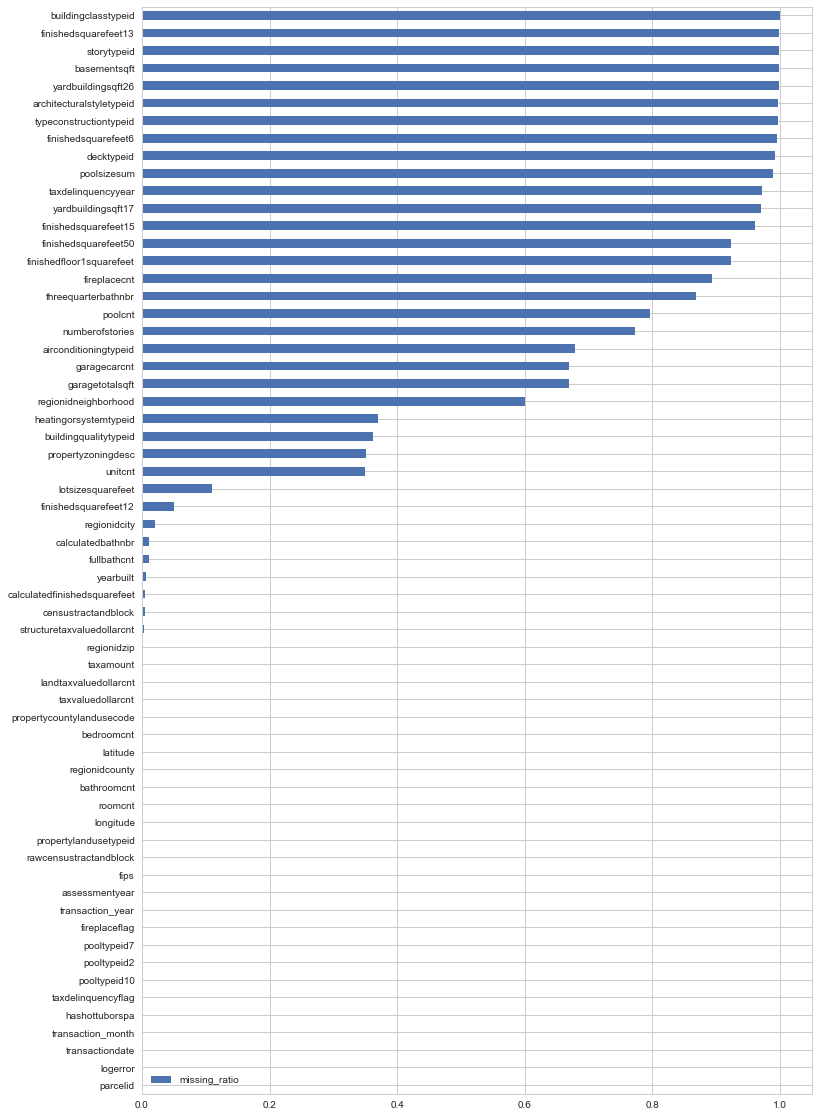

In [98]:
merged_missing.sort_values(by = "missing_ratio", ascending = True).plot(kind = 'barh', figsize=(12,20))

##### Comment:
- missing value ratio가 매우 높은 변수들이 많음
- missing value imputation 방안
    - NaN은 실제로 없어서 그런 것이라고 간주: 0사용
    - 자료가 missing 된 것이라고 볼 경우
        - 연속형 변수: 평균 사용
        - 이산형 변수, 카테고리 변수: 최빈값 사용

### 3.1.3 Missing Values processing

In [55]:
merged_1 = merged.copy()
merged_1.tail()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,raw_census_2,census_3,raw_census_3,census_4,raw_census_4,propertyzoningdesc_1,propertyzoningdesc_3,taxdelinquencyyear_past,census_1,raw_census_1
167883,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,1319.00,1,1,60371,60371,L,R,NaN,6037,6037
167884,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,1014.00,1,1,60371,60371,L,R,NaN,6037,6037
167885,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,0084.02,0,0,61110,61110,NaN,NaN,NaN,6111,6111
167886,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,4338.02,4,4,60374,60374,S,R,NaN,6037,6037
167887,12826780,0.007204,2017-09-25,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,5034.02,5,5,60375,60375,W,R,NaN,6037,6037


#### 일부 변수 추가 후 categorical / numerical 새로 분류
- poolcnt는 dummy variable로 재분류함 (True/False)

In [50]:
vars = merged_des.reset_index()["index"].tolist()
vars.append("taxdelinquencyyear_past")

cat_vars = ['transactiondate',"transaction_year", "transaction_month", 'fips',
            'rawcensustractandblock', 'censustractandblock', "raw_census_1", "census_1",
            "raw_census_2", "census_2", "raw_census_3", "census_3", "raw_census_4", "census_4",
            'regionidcounty', 'regionidcity', 'regionidzip', 'regionidneighborhood', 'architecturalstyletypeid',
            'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 
            'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', "propertyzoningdesc_1", "propertyzoningdesc_3",            
            'taxdelinquencyflag', 'taxdelinquencyyear', 'assessmentyear',
            'heatingorsystemtypeid', 'airconditioningtypeid', 'hashottuborspa', 'fireplaceflag',
            'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'poolcnt']

num_vars = [i for i in vars if i not in cat_vars]

num_vars.remove('parcelid')
num_vars.remove('logerror')

print("number of categorical variables:", len(cat_vars))
print("number of numerical variables:", len(num_vars))

number of categorical variables: 39
number of numerical variables: 32


In [39]:
print(num_vars)

['basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'calculatedbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'latitude', 'longitude', 'lotsizesquarefeet', 'poolsizesum', 'roomcnt', 'threequarterbathnbr', 'unitcnt', 'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt', 'numberofstories', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'taxdelinquencyyear_past']


#### (1) numerical variables:

In [56]:
def num_imputation(df):
    for var in num_vars:
        if var in ["garagecarcnt", "numberofstories"]:
            df[var] = df[var].fillna(1)
        elif var in ["buildingqualitytypeid", "roomcnt", "bedroomcnt", "unitcnt", 'bathroomcnt', 
                     'calculatedbathnbr', 'fullbathcnt', 'threequarterbathnbr', 'yearbuilt']:
            a = df[var].mode()
            df[var] = df[var].fillna(int(a[0]))
        elif var in ['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
                     'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
                     'finishedsquarefeet50', 'finishedsquarefeet6', 'garagetotalsqft', 'lotsizesquarefeet',
                     'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'taxamount',
                     'latitude', 'longitude']:
            df[var] = df[var].fillna(df[var].mean())
        else:    # ['poolsizesum', 'fireplacecnt', 'yardbuildingsqft17', 'yardbuildingsqft26', "poolsizesum","taxdelinquencyyear_past"]
            df[var] = df[var].fillna(0) 

In [57]:
num_imputation(merged_1)

#### (2) dummy/categorical variables:

In [58]:
def cat_imputation(df):
    for var in cat_vars:                  
        if var in ['taxdelinquencyyear', 'assessmentyear']:
            df[var] = df[var].fillna(0)
        elif var == "poolcnt":
            df[var] = df[var].replace(1, True)
            df[var] = df[var].fillna(False)            
        elif var == "decktypeid":
            df[var] = df[var].replace('66.0', True)
            df[var] = df[var].fillna(False)         
        else:
            a = df[var].mode()
            df[var] = df[var].fillna(a[0])

In [59]:
cat_imputation(merged_1)

#### (3) imputation 후 missing value ratio 다시 체크

In [60]:
merged_1_des = merged_1.describe(include='all').transpose()
merged_1_des["missing_ratio"] = 1-(merged_1_des["count"]/merged_1.shape[0])
merged_1_des["dtype"] = merged_1.dtypes
merged_1_missing = pd.DataFrame(merged_1_des["missing_ratio"].sort_values(ascending=False))
merged_1_missing.reset_index()

,index,missing_ratio
0,raw_census_1,0
1,propertylandusetypeid,0
2,fips,0
3,fireplacecnt,0
4,fullbathcnt,0
5,garagecarcnt,0
6,garagetotalsqft,0
7,hashottuborspa,0
8,heatingorsystemtypeid,0
9,latitude,0


## 3.2 Feature Correlation

#### 3.2.1 Numerical Features

- logerror와 높은 선형관계를 가진 numerical feature가 없음
- 서로 높은 관계를 선형관계를 가진 그룹이 보임
    - bedroomcnt & bathroom 관련 변수들, 면적관련 변수들, 세금관련 변수들

In [107]:
num_df = merged_1[num_vars]
num_df["logerror"] = merged_1["logerror"]

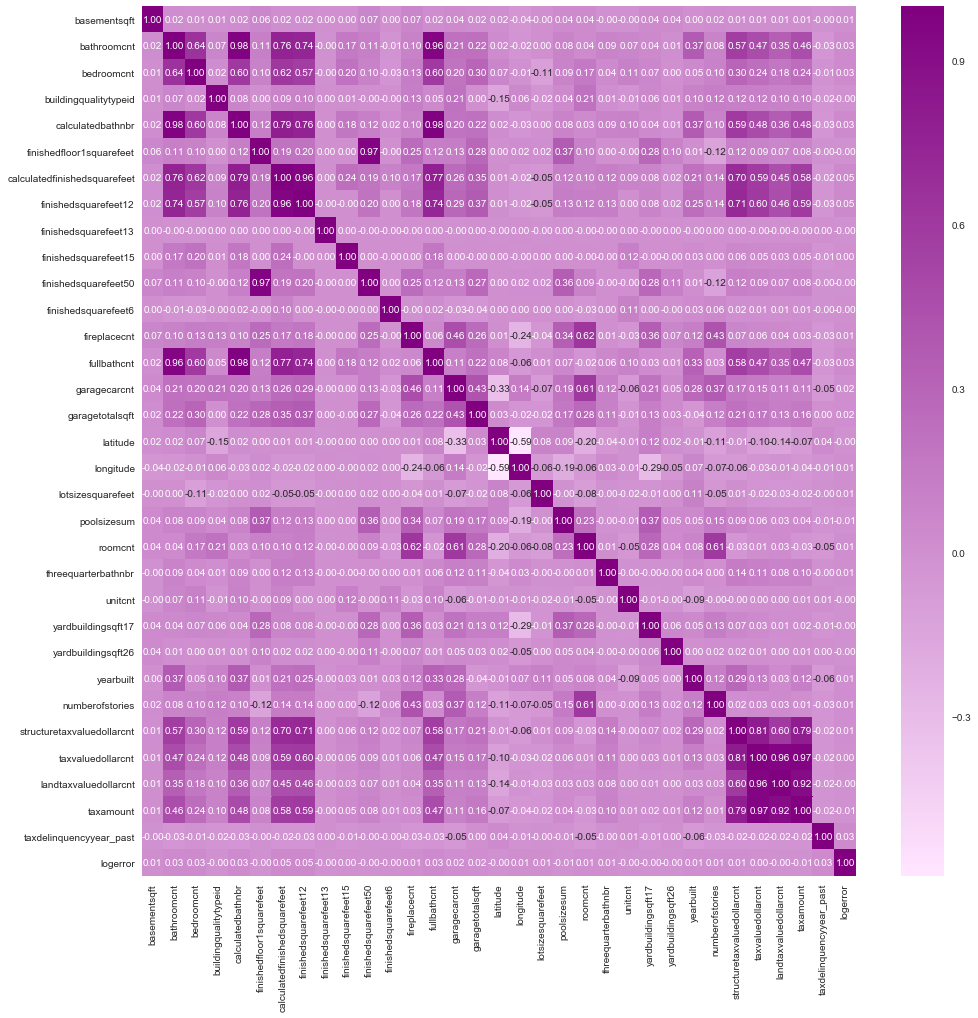

In [108]:
plt.figure(figsize=(16, 16))
cmap = sns.light_palette("purple", as_cmap=True)
sns.heatmap(num_df.corr(), annot=True, fmt='3.2f', cmap=cmap)
plt.show()

#### 3.2.2 Categorical Features

In [109]:
cat_df = merged_1[cat_vars]

In [110]:
cat_dummy_vars = ['decktypeid','taxdelinquencyflag','hashottuborspa','fireplaceflag',\
                  'pooltypeid10','pooltypeid2','pooltypeid7','poolcnt']

In [111]:
cat_dummy_df = cat_df[cat_dummy_vars]

In [112]:
cat_dummy_vif_df = pd.get_dummies(cat_dummy_df)

In [113]:
cat_dummy_vif_df['decktypeid'] = cat_dummy_vif_df['decktypeid'].replace(False,0)
cat_dummy_vif_df['decktypeid'] = cat_dummy_vif_df['decktypeid'].replace(True,1)
cat_dummy_vif_df['taxdelinquencyflag'] = cat_dummy_vif_df['taxdelinquencyflag'].replace(False,0)
cat_dummy_vif_df['taxdelinquencyflag'] = cat_dummy_vif_df['taxdelinquencyflag'].replace(True,1)
cat_dummy_vif_df['hashottuborspa'] = cat_dummy_vif_df['hashottuborspa'].replace(False,0)
cat_dummy_vif_df['hashottuborspa'] = cat_dummy_vif_df['hashottuborspa'].replace(True,1)
cat_dummy_vif_df['fireplaceflag'] = cat_dummy_vif_df['fireplaceflag'].replace(False,0)
cat_dummy_vif_df['fireplaceflag'] = cat_dummy_vif_df['fireplaceflag'].replace(True,1)
cat_dummy_vif_df['pooltypeid10'] = cat_dummy_vif_df['pooltypeid10'].replace(False,0)
cat_dummy_vif_df['pooltypeid10'] = cat_dummy_vif_df['pooltypeid10'].replace(True,1)
cat_dummy_vif_df['pooltypeid2'] = cat_dummy_vif_df['pooltypeid2'].replace(False,0)
cat_dummy_vif_df['pooltypeid2'] = cat_dummy_vif_df['pooltypeid2'].replace(True,1)
cat_dummy_vif_df['pooltypeid7'] = cat_dummy_vif_df['pooltypeid7'].replace(False,0)
cat_dummy_vif_df['pooltypeid7'] = cat_dummy_vif_df['pooltypeid7'].replace(True,1)
cat_dummy_vif_df['poolcnt'] = cat_dummy_vif_df['poolcnt'].replace(False,0)
cat_dummy_vif_df['poolcnt'] = cat_dummy_vif_df['poolcnt'].replace(True,1)

In [114]:
train_cat = pd.concat([merged_1['logerror'], cat_dummy_vif_df], axis=1)
corrmat2 = train_cat.corr()
cor_categorical_cols = corrmat2.nlargest(10, 'logerror')['logerror'].index 
cor_categorical_cols

Index(['logerror', 'taxdelinquencyflag', 'decktypeid', 'fireplaceflag',
       'pooltypeid10', 'hashottuborspa', 'pooltypeid2', 'pooltypeid7',
       'poolcnt'],
      dtype='object')

## 3.3 Numerical Features VIF

In [35]:
# 전체 numerical features
model_n = sm.OLS.from_formula("logerror ~ basementsqft + bathroomcnt + bedroomcnt + calculatedbathnbr +\
finishedfloor1squarefeet + calculatedfinishedsquarefeet + finishedsquarefeet12 + finishedsquarefeet13 +\
finishedsquarefeet15 + finishedsquarefeet50 + finishedsquarefeet6 + fireplacecnt + fullbathcnt + garagecarcnt + garagetotalsqft +\
buildingqualitytypeid + latitude + longitude + lotsizesquarefeet + poolsizesum + roomcnt + threequarterbathnbr +\
unitcnt + yardbuildingsqft17 + yardbuildingsqft26 + yearbuilt + numberofstories + structuretaxvaluedollarcnt + taxvaluedollarcnt +\
landtaxvaluedollarcnt + taxamount + taxdelinquencyyear_past", data=merged_1, missing='drop')
print(model_n.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     26.43
Date:                Fri, 06 Jul 2018   Prob (F-statistic):          1.23e-156
Time:                        14:26:22   Log-Likelihood:                 63985.
No. Observations:              167888   AIC:                        -1.279e+05
Df Residuals:                  167855   BIC:                        -1.276e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [148]:
num_df = merged_1[num_vars]
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(num_df.values, i) for i in range(num_df.shape[1])]
vif["features"] = num_df.columns
vif.sort_values(by="VIF Factor", ascending=False)

,VIF Factor,features
17,150129.783182,longitude
8,112443.292816,finishedsquarefeet13
16,32635.804129,latitude
25,11161.782039,yearbuilt
28,6832.819177,taxvaluedollarcnt
29,3292.795658,landtaxvaluedollarcnt
11,1023.671856,finishedsquarefeet6
27,965.957981,structuretaxvaluedollarcnt
5,945.725129,finishedfloor1squarefeet
10,846.407942,finishedsquarefeet50


##### 전체 numerical features에서 VIF 높은 변수, coef.의 p-value가 높은 변수 제거한 후 scaling
- 전체 numerical features가 들어갔을 때 adf. R2 0.005에서 0.004로 소폭 감소, 조건 수 대폭 개선

In [91]:
model_n1 = sm.OLS.from_formula("logerror ~ scale(latitude) + scale(basementsqft) + scale(bathroomcnt) + scale(finishedsquarefeet12) +\
scale(fireplacecnt) + buildingqualitytypeid + scale(lotsizesquarefeet) + scale(poolsizesum) + roomcnt +\
scale(taxamount) + taxdelinquencyyear_past", data=merged_1, missing='drop')

print(model_n1.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     59.37
Date:                Fri, 06 Jul 2018   Prob (F-statistic):          1.14e-132
Time:                        15:13:30   Log-Likelihood:                 63889.
No. Observations:              167888   AIC:                        -1.278e+05
Df Residuals:                  167876   BIC:                        -1.276e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

## 3.4 One-Way ANOVA Test between Logerror & Categorical Features

In [61]:
ls = ['transaction_year', 'transaction_month', 'raw_census_4', 'fips', 'regionidcity', 'regionidzip', 'architecturalstyletypeid', 'decktypeid', 
      'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 'propertycountylandusecode', 'propertylandusetypeid',
      'propertyzoningdesc_3', 'taxdelinquencyflag', 'taxdelinquencyyear', 'heatingorsystemtypeid', 'airconditioningtypeid', 'hashottuborspa',       
      'fireplaceflag', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'poolcnt']

f_df = pd.DataFrame(columns=["var", "p-value"])

for var in ls:
    formula = ("logerror ~ C({})+0".format(str(var)))
    model = sm.OLS.from_formula(formula, data = merged_1)
    result = sm.stats.anova_lm(model.fit())
    f_df.loc[len(f_df)] = [var, result["PR(>F)"][0]]
    
f_df.sort_values(by='p-value')

,var,p-value
0,transaction_year,0.0
21,pooltypeid2,0.0
20,pooltypeid10,0.0
19,fireplaceflag,0.0
18,hashottuborspa,0.0
17,airconditioningtypeid,0.0
16,heatingorsystemtypeid,0.0
15,taxdelinquencyyear,0.0
14,taxdelinquencyflag,0.0
13,propertyzoningdesc_3,0.0


# 4. Modeling

## 4.1 OLS Model

#### Numerical / Categorical Features를 조합한 Model
- 전체 Numerical Variable을 넣은 모델에서 VIF 점수가 낮고, Coefficient의 p-value 가 낮은 변수 위주로 선택
- 2016/2017년 예측을 위해 year categorical feature를 interaction으로 많이 활용
- properties data에 train data 내에 없는 카테고리 변수의 class가 있을 경우 prediction이 되지 않기 때문에 카테고리 변수의 추가는 최소화하기로 함

In [62]:
model_y1 = sm.OLS.from_formula("logerror ~ C(transaction_year)+0 + C(fips) + scale(yearbuilt) \
                                + C(transaction_year):scale(basementsqft) \
                                + scale(I(bathroomcnt**2)) + C(transaction_year):scale(I(finishedsquarefeet12**2)) \
                                + scale(fireplacecnt) + C(transaction_year):scale(buildingqualitytypeid) \
                                + C(transaction_year):scale(I(lotsizesquarefeet)) \
                                + C(transaction_year):scale(I(poolsizesum**2)) \
                                + C(transaction_year):scale(I(roomcnt**2)) \
                                +scale(taxamount) + scale(I(taxdelinquencyyear_past))", 
                               data=merged_1, missing='drop')
result = model_y1.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     50.71
Date:                Sat, 07 Jul 2018   Prob (F-statistic):          1.63e-201
Time:                        12:12:47   Log-Likelihood:             1.4460e+05
No. Observations:              167888   AIC:                        -2.892e+05
Df Residuals:                  167867   BIC:                        -2.890e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

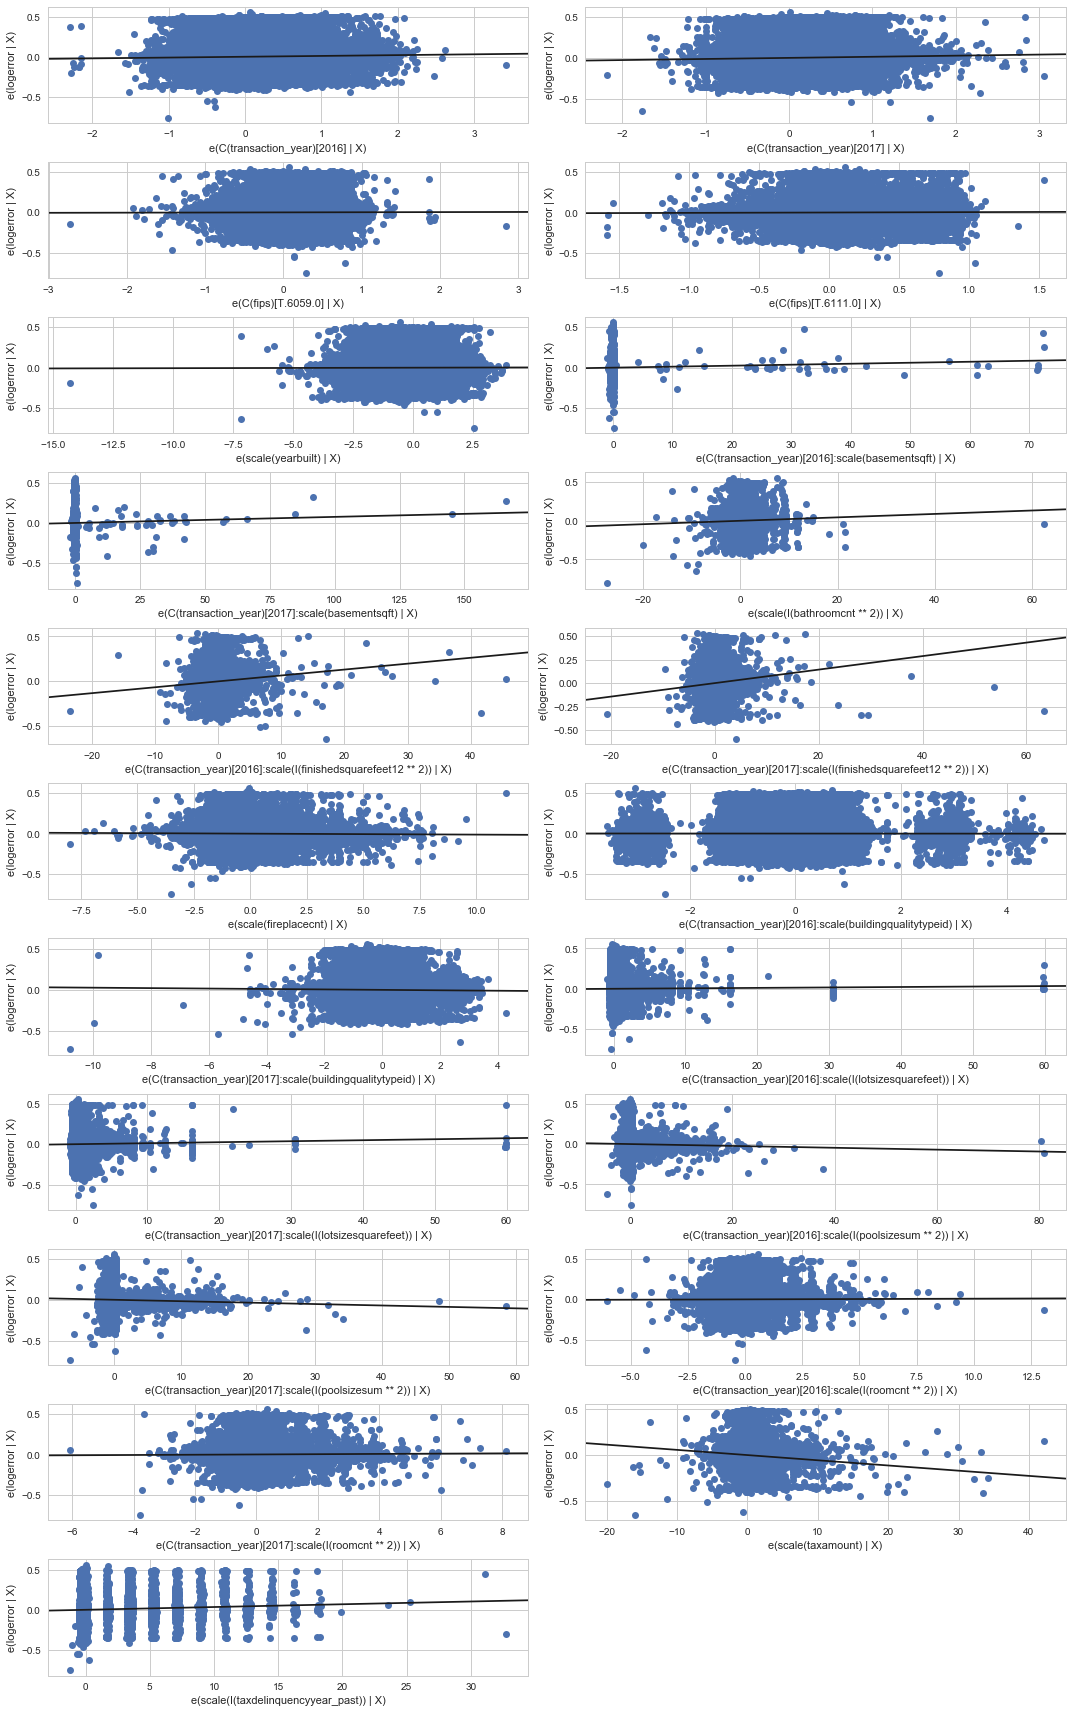

In [116]:
fig = plt.figure(figsize = (15, 25))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

##### 잔차의 정규분포 테스트 결과는 p-value가 매우 낮음 → 정규분포를 따르지 않음

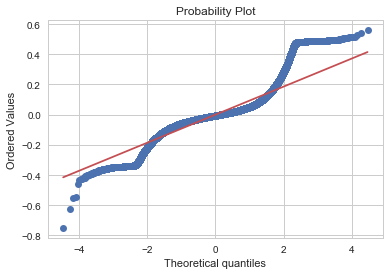

In [117]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

## 4.2 Outlier 제거

##### 4.2.1 아웃라이어 - 표준화 잔차

In [63]:
idx_r = np.where(result.resid_pearson > 2)[0]

##### 4.2.2 Cook's distance

In [64]:
influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(merged_1) - 21 - 1)
idx_c = np.where(cooks_d2 > fox_cr)[0]

In [65]:
resid_outliers = idx_r.tolist()
print("Standardized Residual Outliers", len(resid_outliers), "개 \n")

Standardized Residual Outliers 6019 개 



In [66]:
cooks_outliers = idx_c.tolist()
print("Cook's distance Outliers", len(cooks_outliers), "개 \n")

Cook's distance Outliers 7534 개 



In [67]:
outliers = set(resid_outliers) | set(cooks_outliers)

In [68]:
merged_1_outlier_del = merged_1.drop(outliers)

In [69]:
print("Outlier 삭제 후 data 갯수 ", len(merged_1_outlier_del), "개 \n") 

Outlier 삭제 후 data 갯수  158097 개 



#### 4.2.3 Outlier 제거 후 모델링

In [70]:
model_y2 = sm.OLS.from_formula("logerror ~ C(transaction_year)+0 + C(fips) + scale(yearbuilt) \
                                + C(transaction_year):scale(basementsqft) \
                                + scale(I(bathroomcnt**2)) + C(transaction_year):scale(I(finishedsquarefeet12**2)) \
                                + scale(fireplacecnt) + C(transaction_year):scale(buildingqualitytypeid) \
                                + C(transaction_year):scale(I(lotsizesquarefeet)) \
                                + C(transaction_year):scale(I(poolsizesum**2)) \
                                + C(transaction_year):scale(I(roomcnt**2)) \
                                +scale(taxamount) + scale(I(taxdelinquencyyear_past))", 
                               data=merged_1_outlier_del, missing='drop')
result_2 = model_y2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     125.0
Date:                Sat, 07 Jul 2018   Prob (F-statistic):               0.00
Time:                        12:16:28   Log-Likelihood:             2.0502e+05
No. Observations:              158097   AIC:                        -4.100e+05
Df Residuals:                  158076   BIC:                        -4.098e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

#### 4.2.4 ANOVA F-test

In [126]:
sm.stats.anova_lm(result_2, typ=2)

,sum_sq,df,F,PR(>F)
C(transaction_year),0.178430,2.0,20.382940,1.409104e-09
C(fips),0.427658,2.0,48.853427,6.162835e-22
scale(yearbuilt),0.680640,1.0,155.505665,1.128503e-35
C(transaction_year):scale(basementsqft),0.015075,2.0,1.722038,1.787050e-01
scale(I(bathroomcnt ** 2)),0.363947,1.0,83.150832,7.688104e-20
C(transaction_year):scale(I(finishedsquarefeet12 ** 2)),1.684078,2.0,192.380377,3.562708e-84
scale(fireplacecnt),0.035141,1.0,8.028703,4.604764e-03
C(transaction_year):scale(buildingqualitytypeid),0.264015,2.0,30.159710,8.022368e-14
C(transaction_year):scale(I(lotsizesquarefeet)),0.110369,2.0,12.607964,3.348634e-06
C(transaction_year):scale(I(poolsizesum ** 2)),0.259281,2.0,29.618963,1.377392e-13


#### 4.2.5 각 독립변수와 logerror의 분포

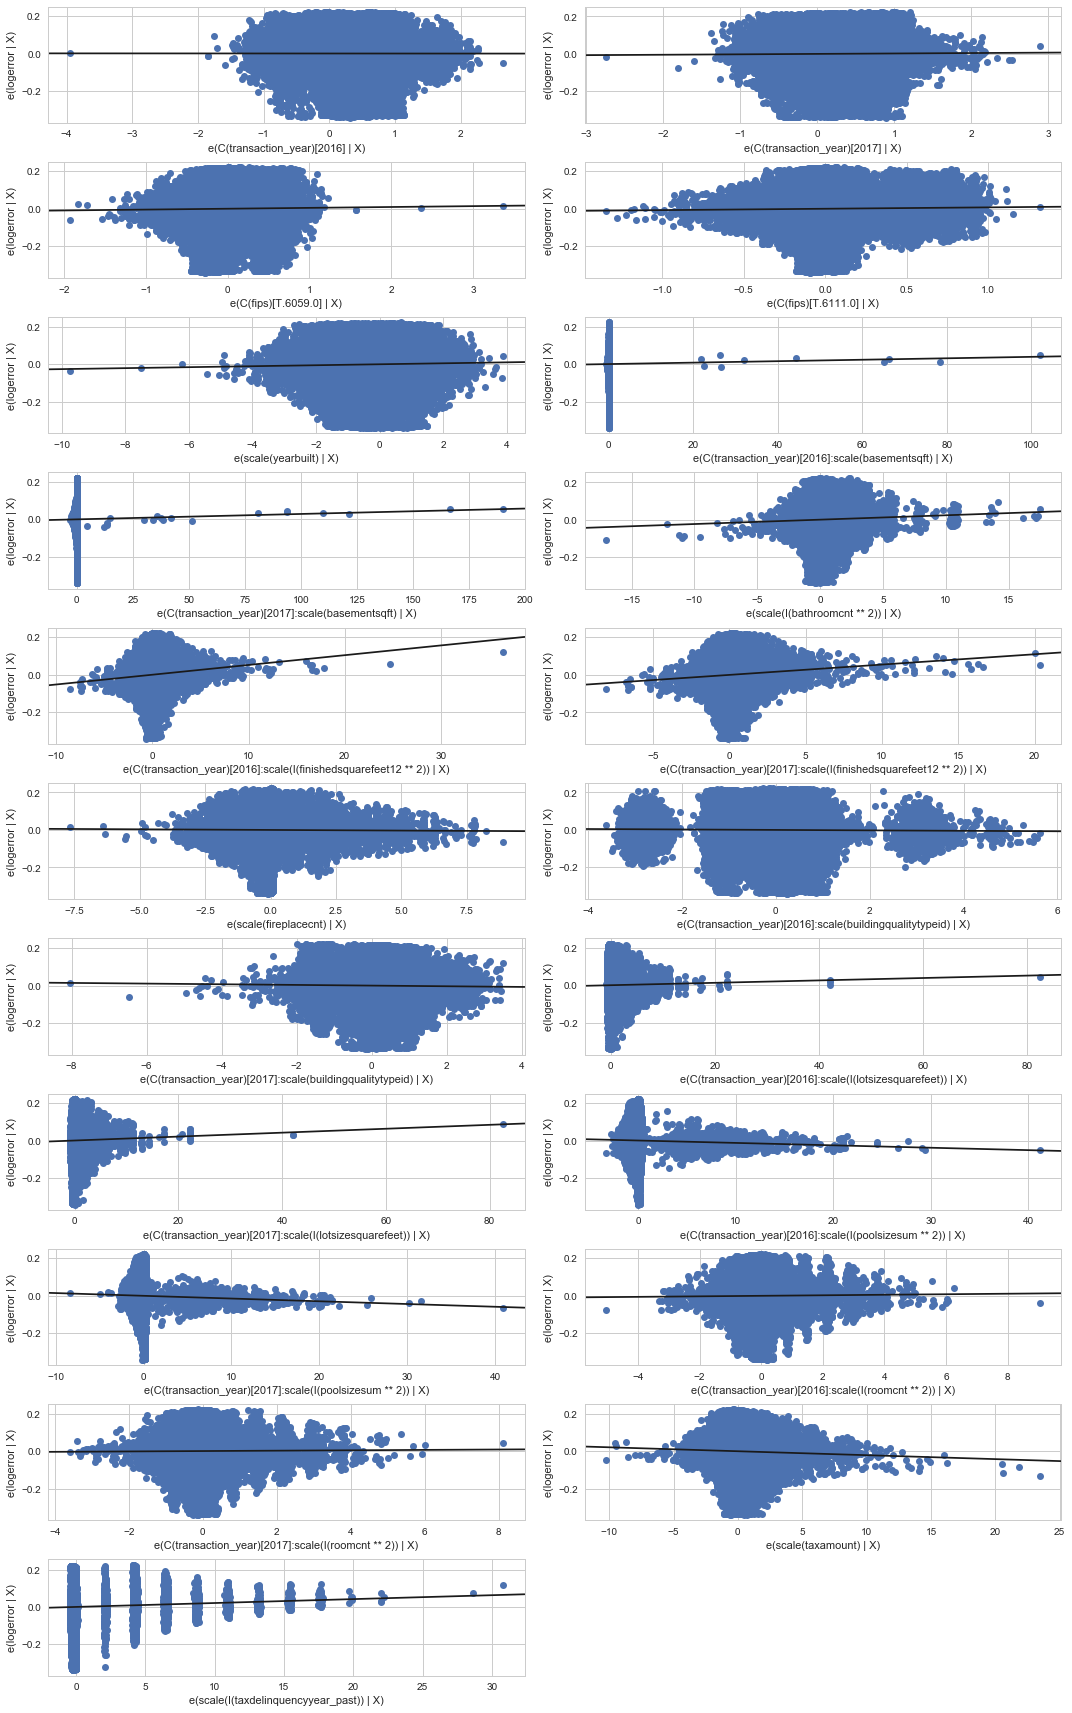

In [128]:
fig = plt.figure(figsize = (15, 25))
sm.graphics.plot_partregress_grid(result_2, fig=fig)
fig.suptitle("")
plt.show()

#### 4.2.6 Normalization of residuals

In [127]:
# Check the chi-squared and p-value of the residuals of the OLS model
test_norm = sms.omni_normtest(result_2.resid)
for xi in zip(['Chi^2', 'P-value'], test_norm):
    print("%-12s: %6.3f" % xi)

Chi^2       : 24639.532
P-value     :  0.000


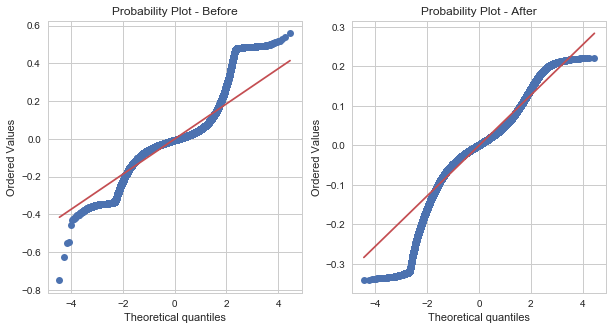

In [130]:
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
res = sp.stats.probplot(result.resid, plot=plt)
ax1.set_title("Probability Plot - Before")
ax2 = plt.subplot(122)
res = sp.stats.probplot(result_2.resid, plot=plt)
ax2.set_title("Probability Plot - After")
plt.show()

## 4.3 Predict Logerror

##### 2016 logerror prediction

In [71]:
test_2016 = pd.read_csv('data/test_2016.csv')

In [72]:
test_2016['fips'] = test_2016['fips'].astype(str)

In [73]:
predict_2016 = result_2.predict(test_2016)

In [74]:
predict_2016_df = pd.DataFrame(columns=['201610','201611','201612'])

In [75]:
predict_2016_df['201610']=predict_2016
predict_2016_df['201611']=predict_2016
predict_2016_df['201612']=predict_2016

##### 2017 logerror prediction

In [5]:
test_2017 = pd.read_csv('data/test_2017.csv')

In [ ]:
test_2017['fips'] = test_2017['fips'].astype(str)

In [ ]:
predict_2017 = result_2.predict(test_2017)

In [ ]:
predict_2017_df = pd.DataFrame(columns=['201710','201711','201712'])

In [ ]:
predict_2017_df['201710']=predict_2017
predict_2017_df['201711']=predict_2017
predict_2017_df['201712']=predict_2017

##### Make submission.csv File

In [ ]:
predict_df = pd.concat([predict_2016_df,predict_2017_df],axis=1)

In [ ]:
parcelid = test_2017['parcelid']

In [ ]:
finial_result = pd.concat([parcelid,predict_df],axis=1).set_index('parcelid')

In [ ]:
finial_result.to_csv('submission.csv')

# 최종 결과

## OLS

![](image/ols_point.png)

![](image/ols_rank.png)

## xgboost

![](image/xgboost_point.png)

![](image/xgboost_rank.png)